# UNeXt 
> https://github.com/jeya-maria-jose/UNeXt-pytorch

In [71]:
%config Completer.use_jedi = False

## 引入依赖包

In [72]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch timm

In [73]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

## 设置wandb账号
用作统计与数据分析

In [74]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin


## ScConv
> https://github.com/XxxxYi/Reproduction_of_ScConv_CVPR2023/blob/main/scconv.py

In [75]:


class GroupNorm2d(nn.Module):

    def __init__(self, n_groups: int = 16, n_channels: int = 16, eps: float = 1e-10):
        super(GroupNorm2d, self).__init__()  
        assert n_channels % n_groups == 0 
        self.n_groups = n_groups  
        self.gamma = nn.Parameter(torch.randn(n_channels, 1, 1))  # learnable gamma
        self.beta = nn.Parameter(torch.zeros(n_channels, 1, 1))  # learnable beta
        self.eps = eps 

    def forward(self, x):
        N, C, H, W = x.size()
        x = x.reshape(N, self.n_groups, -1) 
        mean = x.mean(dim=2, keepdim=True)  
        std = x.std(dim=2, keepdim=True)
        x = (x - mean) / (std + self.eps) 
        x = x.reshape(N, C, H, W)  
        return x * self.gamma + self.beta  


# Spatial and Reconstruct Unit
class SRU(nn.Module):

    def __init__(
            self,
            n_channels: int,  # in_channels
            n_groups: int = 16,  # 16
            gate_treshold: float = 0.5,  # 0.5,
            torch_gn:bool = True
    ):
        super().__init__()  

        # initialize GroupNorm2d
        self.gn = nn.GroupNorm( num_channels = n_channels, num_groups = n_groups ) if torch_gn else GroupNorm2d(n_channels = n_channels, n_groups = n_groups)
        # self.gn = GroupNorm2d(n_groups=n_groups, n_channels=n_channels)
        self.gate_treshold = gate_treshold  
        self.sigomid = nn.Sigmoid()  

    def forward(self, x):
        gn_x = self.gn(x) 
        w_gamma = self.gn.gamma / sum(self.gn.gamma)  # cal gamma weight
        reweights = self.sigomid(gn_x * w_gamma)  # importance

        info_mask = reweights >= self.gate_treshold
        noninfo_mask = reweights < self.gate_treshold
        x_1 = info_mask * x  
        x_2 = noninfo_mask * x  
        x = self.reconstruct(x_1, x_2) 
        return x

    def reconstruct(self, x_1, x_2):
        x_11, x_12 = torch.split(x_1, x_1.size(1) // 2, dim=1)
        x_21, x_22 = torch.split(x_2, x_2.size(1) // 2, dim=1)
        return torch.cat([x_11 + x_22, x_12 + x_21], dim=1)


# Channel Reduction Unit
class CRU(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, alpha: float = 1 / 2, squeeze_radio: int = 2, groups: int = 2):
        super().__init__()

        self.up_channel = up_channel = int(alpha * in_channels)
        self.low_channel = low_channel = in_channels - up_channel
        self.squeeze1 = nn.Conv2d(up_channel, up_channel // squeeze_radio, kernel_size=1, bias=False)
        self.squeeze2 = nn.Conv2d(low_channel, low_channel // squeeze_radio, kernel_size=1, bias=False)

        in_ch = up_channel // squeeze_radio
        out_ch = out_channels
        print("out_channels:", out_channels, "squeeze_radio: ", squeeze_radio, "up_channel: ",up_channel,"in_ch (out_channels // squeeze_radio): ", in_ch, "out_ch(out_channels):", out_ch)
        
        
        if in_ch >= 16:
            groups = 16
    
        self.GWC = nn.Conv2d(in_ch, out_channels, kernel_size=kernel_size, stride=1, padding=kernel_size // 2, groups=groups) 
        self.PWC1 = nn.Conv2d(in_ch, out_channels, kernel_size=1, bias=False)

        print("in_ch: ", in_ch, "out_channels: ", out_channels,"groups: ",groups)
        print("up_channel: ", self.up_channel, "low_channel: ", self.low_channel)
        in_ch = low_channel // squeeze_radio
        out_ch = out_channels - low_channel // squeeze_radio
        print("out_channels:", out_channels, "squeeze_radio: ", squeeze_radio, "low_channel: ",low_channel,"in_ch (low_channel // squeeze_radio): ", in_ch, "out_ch(out_channels - low_channel // squeeze_radio):", out_ch)
        self.PWC2 = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False) 
        #print("self.PWC2.weight.shape: ",self.PWC2.weight.shape)
        self.pool = nn.AdaptiveAvgPool2d(1)  
        
    def forward(self, x):

        up, low = torch.split(x, [self.up_channel, self.low_channel], dim=1)
        up, low = self.squeeze1(up), self.squeeze2(low)

        y1 = self.GWC(up) + self.PWC1(up)
        
        #print("low: ",low.shape)
        pwc2 = self.PWC2(low)
        #print("pwc2", pwc2.shape)
        y2 = torch.cat([pwc2, low], dim=1)

        s1 = self.pool(y1)
        s2 = self.pool(y2)
        s = torch.cat([s1, s2], dim=1)
        beta = F.softmax(s, dim=1)
        beta1, beta2 = torch.split(beta, beta.size(1) // 2, dim=1)
        y = beta1 * y1 + beta2 * y2
        return y


# Squeeze and Channel Reduction Convolution
class ScConv(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, stride: int = 1, padding: int = 1, n_groups: int = 2, gate_treshold: float = 0.5, alpha: float = 1 / 2, squeeze_radio: int = 2, groups: int = 2):
        super().__init__()

        self.SRU = SRU(in_channels, n_groups=n_groups, gate_treshold=gate_treshold, torch_gn=False) 
        self.CRU = CRU(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, alpha=alpha, squeeze_radio=squeeze_radio, groups=groups)

    def forward(self, x):
        x = self.SRU(x)  
        x = self.CRU(x) 
        return x




CE-NET中DAC模块

In [76]:
from functools import partial

nonlinearity = partial(F.relu, inplace=True)

class DACblock(nn.Module):
    def __init__(self, channel):
        super(DACblock, self).__init__()
        self.dilate1 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.dilate2 = nn.Conv2d(channel, channel, kernel_size=3, dilation=3, padding=3)
        self.dilate3 = nn.Conv2d(channel, channel, kernel_size=3, dilation=5, padding=5)
        self.conv1x1 = nn.Conv2d(channel, channel, kernel_size=1, dilation=1, padding=0)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        dilate1_out = nonlinearity(self.dilate1(x))
        dilate2_out = nonlinearity(self.conv1x1(self.dilate2(x)))
        dilate3_out = nonlinearity(self.conv1x1(self.dilate2(self.dilate1(x))))
        dilate4_out = nonlinearity(self.conv1x1(self.dilate3(self.dilate2(self.dilate1(x)))))
        out = x + dilate1_out + dilate2_out + dilate3_out + dilate4_out
        return out

class SPPblock(nn.Module):
    def __init__(self, in_channels):
            super(SPPblock, self).__init__()
            self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=[3, 3], stride=3)
            self.pool3 = nn.MaxPool2d(kernel_size=[5, 5], stride=5)
            self.pool4 = nn.MaxPool2d(kernel_size=[6, 6], stride=6)

            self.conv = nn.Conv2d(in_channels=in_channels, out_channels=1, kernel_size=1, padding=0)

    def forward(self, x):
        self.in_channels, h, w = x.size(1), x.size(2), x.size(3)
        self.layer1 = F.upsample(self.conv(self.pool1(x)), size=(h, w), mode='bilinear')
        self.layer2 = F.upsample(self.conv(self.pool2(x)), size=(h, w), mode='bilinear')
        self.layer3 = F.upsample(self.conv(self.pool3(x)), size=(h, w), mode='bilinear')
        self.layer4 = F.upsample(self.conv(self.pool4(x)), size=(h, w), mode='bilinear')

        out = torch.cat([self.layer1, self.layer2, self.layer3, self.layer4, x], 1)

        return out


In [77]:
import torch
from torch import nn
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
# from utils import *

import timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import types
import math
from abc import ABCMeta, abstractmethod
# from mmcv.cnn import ConvModule
import pdb



# def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
#     """1x1 convolution"""
#     return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, bias=False)


def shift(dim):
            x_shift = [ torch.roll(x_c, shift, dim) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
            x_cat = torch.cat(x_shift, 1)
            x_cat = torch.narrow(x_cat, 2, self.pad, H)
            x_cat = torch.narrow(x_cat, 3, self.pad, W)
            return x_cat

class shiftmlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., shift_size=5):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.dim = in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.shift_size = shift_size
        self.pad = shift_size // 2

        
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()
    
#     def shift(x, dim):
#         x = F.pad(x, "constant", 0)
#         x = torch.chunk(x, shift_size, 1)
#         x = [ torch.roll(x_c, shift, dim) for x_s, shift in zip(x, range(-pad, pad+1))]
#         x = torch.cat(x, 1)
#         return x[:, :, pad:-pad, pad:-pad]

    def forward(self, x, H, W):
        # pdb.set_trace()
        B, N, C = x.shape

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 2) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)


        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_r = x_s.transpose(1,2)


        x = self.fc1(x_shift_r)

        x = self.dwconv(x, H, W)
        x = self.act(x) 
        x = self.drop(x)

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 3) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)
        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_c = x_s.transpose(1,2)

        x = self.fc2(x_shift_c)
        x = self.drop(x)
        return x



class shiftedBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()


        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = shiftmlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):

        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))
        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x

class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class UNext(nn.Module):

    ## Conv 3 + scconv1 + shifted MLP +DAC
    
    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=16, in_chans=3,  embed_dims=[ 256, 512, 512 ],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()
        self.num_classes = num_classes
        self.input_channels = input_channels
        
        self.encoder1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)  
        self.encoder2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)  
        self.encoder3 = nn.Conv2d(32, 128, 3, stride=1, padding=1)
        self.encoder4 = ScConv(128, 256, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(16)
        self.ebn2 = nn.BatchNorm2d(32)
        self.ebn3 = nn.BatchNorm2d(128)
        self.ebn4 = nn.BatchNorm2d(256)
        
        self.norm3 = norm_layer(512)
        #self.norm4 = norm_layer(embed_dims[2])

#         self.dnorm3 = norm_layer(512)
        self.dnorm4 = norm_layer(256)

    
        
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])#256

#         self.block2 = nn.ModuleList([shiftedBlock(
#             dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
#             drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
#             sr_ratio=sr_ratios[0])])#512

#         self.dblock1 = nn.ModuleList([shiftedBlock(
#             dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
#             drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
#             sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])
        

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])#（256，512）
        #self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
        #                                      embed_dim=embed_dims[2])#（256，512）
        self.dac = DACblock(512)
        self.spp = SPPblock(512)
        #self.conv = nn.Conv2d(516, 512, 1, stride=1)
        
        self.decoder1 =   nn.Conv2d(516, 256, 3, stride=1,padding=1) 
        self.decoder2 =   ScConv(256, 128, 3, stride=1, padding=1)  
        self.decoder3 =   nn.Conv2d(128, 32, 3, stride=1, padding=1) 
        self.decoder4 =   nn.Conv2d(32, 16, 3, stride=1, padding=1)
        self.decoder5 =   nn.Conv2d(16, 16, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(256)
        self.dbn2 = nn.BatchNorm2d(128)
        self.dbn3 = nn.BatchNorm2d(32)
        self.dbn4 = nn.BatchNorm2d(16)
        
        self.final = nn.Conv2d(16, num_classes, kernel_size=1)

        self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        e1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        e2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        e3 = out
        ### Stage 4
        out = F.relu(F.max_pool2d(self.ebn4(self.encoder4(out)),2,2))
        e4 = out
        
        
        ### Tokenized MLP Stage
        ### Stage 5

        out,H,W = self.patch_embed3(e4)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        e5 = out
        ### Bottleneck

#         out ,H,W= self.patch_embed4(out)
#         for i, blk in enumerate(self.block2):
#             out = blk(out, H, W)
#         out = self.norm4(out)
#         out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        
#         out = F.max_pool2d(out,2,2)


        out = self.dac(out) 
        print("DAC=",out.shape)
        out = self.spp(out)
        print("SPP=",out.shape)
        
#         out = self.norm4(out)
#         out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

#         out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
#         out = self.conv(out)
#         out = torch.add(out,e4)
#         print("outstage4=",out.shape)
        
#         _,_,H,W = out.shape
#         out = out.flatten(2).transpose(1,2)
#         for i, blk in enumerate(self.dblock1):
#             out = blk(out, H, W)
#         out = self.dnorm3(out)
#         out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        ### Stage 3
         
        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,e4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
    
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)
        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,e3)
        
        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,e2)
        
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,e1)
    
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))
        return self.final(out)
#         if self.training:
#             return final
#         else:
            
#             return self.soft(final)


# class UNext_S(nn.Module):

#     ## Conv 3 + MLP 2 + shifted MLP w less parameters
    
#     def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=16, in_chans=3,  embed_dims=[32, 64, 128, 512],
#                  num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
#                  attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
#                  depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
#         super().__init__()
#         self.input_channels = input_channels
#         self.num_classes = num_classes
#         self.encoder1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)  
#         self.encoder2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)  
#         self.encoder3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)

#         self.ebn1 = nn.BatchNorm2d(8)
#         self.ebn2 = nn.BatchNorm2d(16)
#         self.ebn3 = nn.BatchNorm2d(32)
        
#         self.norm3 = norm_layer(embed_dims[1])
#         self.norm4 = norm_layer(embed_dims[2])

#         self.dnorm3 = norm_layer(64)
#         self.dnorm4 = norm_layer(32)

#         dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

#         self.block1 = nn.ModuleList([shiftedBlock(
#             dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
#             drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
#             sr_ratio=sr_ratios[0])])

#         self.block2 = nn.ModuleList([shiftedBlock(
#             dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
#             drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
#             sr_ratio=sr_ratios[0])])

#         self.dblock1 = nn.ModuleList([shiftedBlock(
#             dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
#             drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
#             sr_ratio=sr_ratios[0])])

#         self.dblock2 = nn.ModuleList([shiftedBlock(
#             dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
#             drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
#             sr_ratio=sr_ratios[0])])

#         self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
#                                               embed_dim=embed_dims[1])
#         self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
#                                               embed_dim=embed_dims[2])

#         self.decoder1 =  nn.Conv2d(128, 64, 3, stride=1,padding=1)  
#         self.decoder2 =  nn.Conv2d(64, 32, 3, stride=1, padding=1)  
#         self.decoder3 =  nn.Conv2d(32, 16, 3, stride=1, padding=1) 
#         self.decoder4 =  nn.Conv2d(16, 8, 3, stride=1, padding=1)
#         self.decoder5 =  nn.Conv2d(8, 8, 3, stride=1, padding=1)

#         self.dbn1 = nn.BatchNorm2d(64)
#         self.dbn2 = nn.BatchNorm2d(32)
#         self.dbn3 = nn.BatchNorm2d(16)
#         self.dbn4 = nn.BatchNorm2d(8)
        
#         self.final = nn.Conv2d(8, num_classes, kernel_size=1)

#         self.soft = nn.Softmax(dim =1)

#     def forward(self, x):
        
#         B = x.shape[0]
#         ### Encoder
#         ### Conv Stage

#         ### Stage 1
#         out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
#         t1 = out
#         ### Stage 2
#         out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
#         t2 = out
#         ### Stage 3
#         out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
#         t3 = out

#         ### Tokenized MLP Stage
#         ### Stage 4

#         out,H,W = self.patch_embed3(out)
#         for i, blk in enumerate(self.block1):
#             out = blk(out, H, W)
#         out = self.norm3(out)
#         out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
#         t4 = out

#         ### Bottleneck

#         out ,H,W= self.patch_embed4(out)
#         for i, blk in enumerate(self.block2):
#             out = blk(out, H, W)
#         out = self.norm4(out)
#         out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

#         ### Stage 4

#         out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        
#         out = torch.add(out,t4)
#         _,_,H,W = out.shape
#         out = out.flatten(2).transpose(1,2)
#         for i, blk in enumerate(self.dblock1):
#             out = blk(out, H, W)

#         ### Stage 3
        
#         out = self.dnorm3(out)
#         out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
#         out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
#         out = torch.add(out,t3)
#         _,_,H,W = out.shape
#         out = out.flatten(2).transpose(1,2)
        
#         for i, blk in enumerate(self.dblock2):
#             out = blk(out, H, W)

#         out = self.dnorm4(out)
#         out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

#         out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
#         out = torch.add(out,t2)
#         out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
#         out = torch.add(out,t1)
#         out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

#         return self.final(out)


# #EOF


# ## DataSet

In [78]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size, channels = 3) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        transformers = [
            transforms.Resize(size),
            transforms.ToTensor()
        ]
        if channels == 1:
            transformers.insert(0, transforms.Grayscale(num_output_channels=1))

        # 设置 transforms
        self.transform = transforms.Compose(transformers)
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path) 
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path) 

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        orig_img = self.transform(orig_img)
        mask_img = self.transform(mask_img)
#         mask_img = mask_img[0]
#         if orig_img.size()[0] != 3:
#             print("{}: orig_img size: {}".format(index,orig_img.size()))
#             return None
        # return data, mask (X, y)
        return orig_img, mask_img


In [79]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


### 检查异常图片
要把找到的异常数据去除

In [80]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
showing image of 537: 


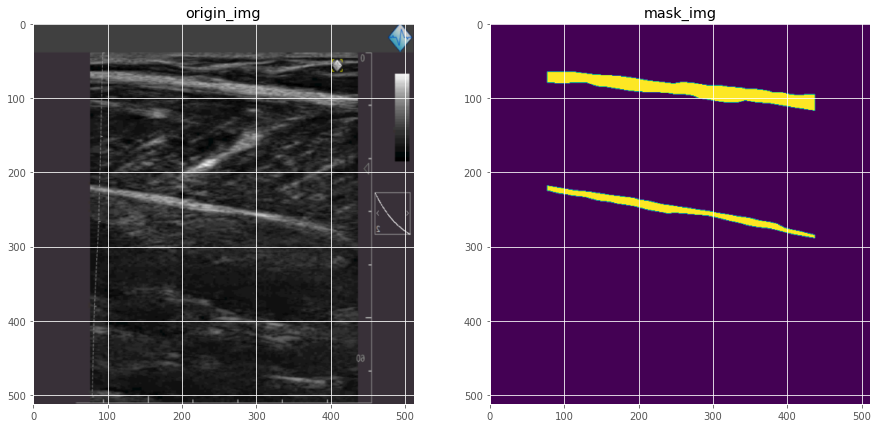

In [81]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]
print(orig_img.size())

transform = transforms.ToPILImage()
print("showing image of {}: ".format(idx))

orig_img = transform(orig_img)
mask_img = transform(mask_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.set_title("origin_img")

ax2.imshow(mask_img)
ax2.set_title("mask_img")

plt.show()

## 模型训练

In [82]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        num_classes = net.module.num_classes
    else:
        num_classes = net.num_classes
    criterion = nn.CrossEntropyLoss() if num_classes > 1 else nn.BCEWithLogitsLoss()
    dice_loss = smp.losses.DiceLoss(mode='binary', log_loss=True, from_logits = True).cuda()
   
    
    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            mask_pred = net(image)
            dice_score += criterion(mask_pred, mask_true.float())
            dice_score += dice_loss(mask_pred, mask_true)
            
            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask_true.long(), mode='binary', threshold=0.5)
            iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            
    dice_loss = (dice_score / max(num_val_batches, 1))
    iou_score = (iou_score / max(num_val_batches, 1))
    print("Validation dice loss: {}, IoU Score {}".format(dice_loss, iou_score))
    return (dice_loss, iou_score)

In [83]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)
soft = nn.Softmax(dim =1)

def train(model, device, 
          project = 'U-Net',
          epochs: int = 60,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          val_percent: float = 0.1,
          gradient_clipping: float = 1.0):
    
    if isinstance(model, nn.DataParallel):
        num_classes = model.module.num_classes
        input_channels = model.module.input_channels
    else:
        num_classes = model.num_classes
        input_channels = model.input_channels
        
    # (Initialize logging)
    experiment = wandb.init(project=project, resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')
    

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     optimizer = optim.SGD(params, lr=config['lr'], momentum=config['momentum'],
#                               nesterov=config['nesterov'], weight_decay=config['weight_decay'])

    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    
    criterion = nn.CrossEntropyLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary').cuda()
    
    global_step = 0
    

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == input_channels, \
                    f'Network has been defined with {input_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss(masks_pred, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(masks_pred, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not value.grad is None:
                                if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                    histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        model.train()
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            masks_pred[0] = soft(masks_pred[0])
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation IoU Score': iou_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass
            


In [84]:
model = UNext(input_channels=3, num_classes=1, img_size=512)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model = model.to(memory_format=torch.channels_last)
model.to(device)


total_params = sum(p.numel() for p in model.parameters())
print(f"CE-U-Next-ScConv-onelayer模型参数量为：{total_params}")
print("其详情为：")
for name,parameters in model.named_parameters():
    print(name,':',parameters.size())

train(model, device, project='CE-U-Next-ScConv-onelayer')


out_channels: 256 squeeze_radio:  2 up_channel:  64 in_ch (out_channels // squeeze_radio):  32 out_ch(out_channels): 256
in_ch:  32 out_channels:  256 groups:  16
up_channel:  64 low_channel:  64
out_channels: 256 squeeze_radio:  2 low_channel:  64 in_ch (low_channel // squeeze_radio):  32 out_ch(out_channels - low_channel // squeeze_radio): 224
out_channels: 128 squeeze_radio:  2 up_channel:  128 in_ch (out_channels // squeeze_radio):  64 out_ch(out_channels): 128
in_ch:  64 out_channels:  128 groups:  16
up_channel:  128 low_channel:  128
out_channels: 128 squeeze_radio:  2 low_channel:  128 in_ch (low_channel // squeeze_radio):  64 out_ch(out_channels - low_channel // squeeze_radio): 64
Let's use 2 GPUs!
CE-U-Next-ScConv-onelayer模型参数量为：10526706
其详情为：
module.encoder1.weight : torch.Size([16, 3, 3, 3])
module.encoder1.bias : torch.Size([16])
module.encoder2.weight : torch.Size([32, 16, 3, 3])
module.encoder2.bias : torch.Size([32])
module.encoder3.weight : torch.Size([128, 32, 3, 3])


Epoch 1/60:   0%|          | 0/456 [00:00<?, ?img/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   1%|          | 4/456 [00:01<02:46,  2.72img/s, loss (batch)=0.897]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   1%|▏         | 6/456 [00:01<01:55,  3.91img/s, loss (batch)=0.874]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   2%|▏         | 8/456 [00:02<01:29,  5.02img/s, loss (batch)=0.903]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   2%|▏         | 10/456 [00:02<01:16,  5.85img/s, loss (batch)=0.911]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   3%|▎         | 12/456 [00:02<01:08,  6.48img/s, loss (batch)=0.863]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   3%|▎         | 14/456 [00:02<01:05,  6.73img/s, loss (batch)=0.957]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   4%|▎         | 16/456 [00:03<01:05,  6.77img/s, loss (batch)=0.922]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   4%|▍         | 18/456 [00:03<01:06,  6.62img/s, loss (batch)=0.963]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   4%|▍         | 20/456 [00:03<00:59,  7.30img/s, loss (batch)=0.877]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   5%|▍         | 22/456 [00:03<00:56,  7.72img/s, loss (batch)=0.906]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   5%|▌         | 24/456 [00:04<00:54,  7.86img/s, loss (batch)=0.917]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   6%|▌         | 26/456 [00:04<00:52,  8.11img/s, loss (batch)=0.899]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   6%|▌         | 28/456 [00:04<00:51,  8.28img/s, loss (batch)=0.938]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   7%|▋         | 30/456 [00:04<00:51,  8.24img/s, loss (batch)=0.934]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   7%|▋         | 32/456 [00:05<00:51,  8.20img/s, loss (batch)=0.941]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   7%|▋         | 34/456 [00:05<00:50,  8.31img/s, loss (batch)=0.914]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   8%|▊         | 36/456 [00:05<00:52,  7.98img/s, loss (batch)=0.951]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   8%|▊         | 38/456 [00:05<00:52,  7.89img/s, loss (batch)=0.928]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   9%|▉         | 40/456 [00:06<00:50,  8.20img/s, loss (batch)=0.882]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:   9%|▉         | 42/456 [00:06<00:48,  8.49img/s, loss (batch)=0.886]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  10%|▉         | 44/456 [00:06<00:48,  8.42img/s, loss (batch)=0.909]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  10%|█         | 46/456 [00:06<00:48,  8.46img/s, loss (batch)=0.914]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  11%|█         | 48/456 [00:07<00:48,  8.35img/s, loss (batch)=0.92] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  11%|█         | 50/456 [00:07<00:49,  8.16img/s, loss (batch)=0.937]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  11%|█▏        | 52/456 [00:07<00:49,  8.14img/s, loss (batch)=0.918]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  12%|█▏        | 54/456 [00:07<00:49,  8.19img/s, loss (batch)=0.941]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  12%|█▏        | 56/456 [00:08<00:48,  8.24img/s, loss (batch)=0.934]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  13%|█▎        | 58/456 [00:08<00:46,  8.53img/s, loss (batch)=0.919]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  13%|█▎        | 60/456 [00:08<00:46,  8.50img/s, loss (batch)=0.938]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  14%|█▎        | 62/456 [00:08<00:47,  8.22img/s, loss (batch)=0.946]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  14%|█▍        | 64/456 [00:09<00:46,  8.35img/s, loss (batch)=0.913]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  14%|█▍        | 66/456 [00:09<00:46,  8.30img/s, loss (batch)=0.954]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  15%|█▍        | 68/456 [00:09<00:45,  8.45img/s, loss (batch)=0.865]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  15%|█▌        | 70/456 [00:09<00:45,  8.44img/s, loss (batch)=0.922]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  16%|█▌        | 72/456 [00:09<00:45,  8.40img/s, loss (batch)=0.933]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  16%|█▌        | 74/456 [00:10<00:44,  8.56img/s, loss (batch)=0.905]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  17%|█▋        | 76/456 [00:10<00:47,  8.07img/s, loss (batch)=0.942]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  17%|█▋        | 78/456 [00:10<00:45,  8.24img/s, loss (batch)=0.925]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  18%|█▊        | 80/456 [00:10<00:46,  8.09img/s, loss (batch)=0.936]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  18%|█▊        | 82/456 [00:11<00:46,  8.04img/s, loss (batch)=0.918]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  18%|█▊        | 84/456 [00:11<00:43,  8.47img/s, loss (batch)=0.882]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  19%|█▉        | 86/456 [00:11<00:44,  8.37img/s, loss (batch)=0.905]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  19%|█▉        | 88/456 [00:11<00:43,  8.40img/s, loss (batch)=0.938]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  20%|█▉        | 90/456 [00:12<00:43,  8.46img/s, loss (batch)=0.88] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:18,  6.14batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:15,  7.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   4%|▍         | 5/115 [00:00<00:14,  7.69batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   6%|▌         | 7/115 [00:00<00:13,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   8%|▊         | 9/115 [00:01<00:12,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.00batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  7.92batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  13%|█▎        | 15/115 [00:01<00:12,  7.94batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:12,  7.95batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:12,  7.89batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  20%|██        | 23/115 [00:02<00:11,  7.96batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:11,  7.93batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  7.90batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  7.82batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  7.87batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  30%|███       | 35/115 [00:04<00:10,  7.94batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  34%|███▍      | 39/115 [00:04<00:09,  7.98batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:05<00:09,  8.00batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  37%|███▋      | 43/115 [00:05<00:09,  7.91batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  39%|███▉      | 45/115 [00:05<00:08,  8.04batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 49/115 [00:06<00:08,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  44%|████▍     | 51/115 [00:06<00:07,  8.07batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  7.93batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  7.95batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:07<00:07,  7.88batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  51%|█████▏    | 59/115 [00:07<00:07,  7.97batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.01batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:08<00:06,  7.99batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  58%|█████▊    | 67/115 [00:08<00:06,  7.89batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  7.87batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:09<00:05,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  65%|██████▌   | 75/115 [00:09<00:04,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  7.63batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  71%|███████▏  | 82/115 [00:10<00:04,  7.99batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:04,  7.76batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  7.54batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  7.52batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:11<00:03,  7.58batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:03,  7.82batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  81%|████████  | 93/115 [00:11<00:02,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:12<00:02,  6.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:02,  7.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  7.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|████████▉ | 103/115 [00:13<00:01,  7.63batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:13<00:01,  8.02batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:13<00:01,  7.73batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  7.55batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:14<00:00,  7.71batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  98%|█████████▊| 113/115 [00:14<00:00,  7.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:14<00:00,  7.84batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 3.416611433029175, IoU Score 0.2569589614868164


Epoch 1/60:  20%|██        | 92/456 [00:27<14:47,  2.44s/img, loss (batch)=0.915]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  21%|██        | 94/456 [00:28<10:30,  1.74s/img, loss (batch)=0.903]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  21%|██        | 96/456 [00:28<07:32,  1.26s/img, loss (batch)=0.912]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  21%|██▏       | 98/456 [00:28<05:28,  1.09img/s, loss (batch)=0.939]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  22%|██▏       | 100/456 [00:28<04:02,  1.47img/s, loss (batch)=0.928]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  22%|██▏       | 102/456 [00:29<03:02,  1.94img/s, loss (batch)=0.925]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  23%|██▎       | 104/456 [00:29<02:19,  2.52img/s, loss (batch)=0.949]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  23%|██▎       | 106/456 [00:29<01:48,  3.22img/s, loss (batch)=0.889]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  24%|██▎       | 108/456 [00:29<01:27,  3.96img/s, loss (batch)=0.896]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  24%|██▍       | 110/456 [00:30<01:13,  4.70img/s, loss (batch)=0.902]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  25%|██▍       | 112/456 [00:30<01:02,  5.48img/s, loss (batch)=0.905]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  25%|██▌       | 114/456 [00:30<00:56,  6.10img/s, loss (batch)=0.921]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  25%|██▌       | 116/456 [00:30<00:51,  6.57img/s, loss (batch)=0.943]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  26%|██▌       | 118/456 [00:30<00:47,  7.15img/s, loss (batch)=0.862]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  26%|██▋       | 120/456 [00:31<00:45,  7.34img/s, loss (batch)=0.933]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  27%|██▋       | 122/456 [00:31<00:43,  7.75img/s, loss (batch)=0.897]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  27%|██▋       | 124/456 [00:31<00:42,  7.76img/s, loss (batch)=0.926]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  28%|██▊       | 126/456 [00:31<00:41,  7.98img/s, loss (batch)=0.911]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  28%|██▊       | 128/456 [00:32<00:41,  7.95img/s, loss (batch)=0.918]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  29%|██▊       | 130/456 [00:32<00:40,  8.10img/s, loss (batch)=0.925]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  29%|██▉       | 132/456 [00:32<00:39,  8.30img/s, loss (batch)=0.915]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  29%|██▉       | 134/456 [00:32<00:39,  8.23img/s, loss (batch)=0.931]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  30%|██▉       | 136/456 [00:33<00:39,  8.06img/s, loss (batch)=0.927]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  30%|███       | 138/456 [00:33<00:40,  7.90img/s, loss (batch)=0.927]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  31%|███       | 140/456 [00:33<00:39,  7.98img/s, loss (batch)=0.848]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  32%|███▏      | 144/456 [00:34<00:45,  6.80img/s, loss (batch)=0.931]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  32%|███▏      | 146/456 [00:34<00:44,  7.01img/s, loss (batch)=0.945]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  32%|███▏      | 148/456 [00:34<00:40,  7.60img/s, loss (batch)=0.912]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  33%|███▎      | 150/456 [00:35<00:39,  7.82img/s, loss (batch)=0.935]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  33%|███▎      | 152/456 [00:35<00:37,  8.01img/s, loss (batch)=0.917]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  34%|███▍      | 154/456 [00:35<00:36,  8.29img/s, loss (batch)=0.901]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  34%|███▍      | 156/456 [00:35<00:35,  8.45img/s, loss (batch)=0.912]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  35%|███▍      | 158/456 [00:35<00:34,  8.69img/s, loss (batch)=0.877]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  35%|███▌      | 160/456 [00:36<00:34,  8.59img/s, loss (batch)=0.94] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  36%|███▌      | 162/456 [00:36<00:34,  8.54img/s, loss (batch)=0.92]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  36%|███▌      | 164/456 [00:36<00:34,  8.54img/s, loss (batch)=0.943]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  36%|███▋      | 166/456 [00:36<00:34,  8.46img/s, loss (batch)=0.937]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  37%|███▋      | 168/456 [00:37<00:33,  8.48img/s, loss (batch)=0.91] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  37%|███▋      | 170/456 [00:37<00:33,  8.44img/s, loss (batch)=0.89]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  38%|███▊      | 172/456 [00:37<00:32,  8.66img/s, loss (batch)=0.833]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  38%|███▊      | 174/456 [00:37<00:32,  8.73img/s, loss (batch)=0.899]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  39%|███▊      | 176/456 [00:38<00:32,  8.66img/s, loss (batch)=0.913]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  39%|███▉      | 178/456 [00:38<00:31,  8.75img/s, loss (batch)=0.899]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  39%|███▉      | 180/456 [00:38<00:32,  8.60img/s, loss (batch)=0.944]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:12,  8.87batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.51batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   5%|▌         | 6/115 [00:00<00:12,  8.42batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   6%|▌         | 7/115 [00:00<00:12,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   9%|▊         | 10/115 [00:01<00:12,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  7.96batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  13%|█▎        | 15/115 [00:01<00:12,  7.90batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:12,  7.82batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:12,  7.54batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  7.91batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  20%|██        | 23/115 [00:02<00:11,  7.80batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:11,  7.67batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.02batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.07batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  7.65batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  7.62batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  30%|███       | 35/115 [00:04<00:10,  7.82batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  34%|███▍      | 39/115 [00:04<00:09,  7.94batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:05<00:09,  7.79batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  37%|███▋      | 43/115 [00:05<00:09,  7.79batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  40%|████      | 46/115 [00:05<00:08,  8.01batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  7.92batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 49/115 [00:06<00:08,  8.04batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  44%|████▍     | 51/115 [00:06<00:07,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:07<00:07,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  52%|█████▏    | 60/115 [00:07<00:06,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:08<00:06,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  58%|█████▊    | 67/115 [00:08<00:06,  7.97batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:09<00:05,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  66%|██████▌   | 76/115 [00:09<00:04,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  7.98batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  70%|███████   | 81/115 [00:10<00:04,  7.84batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:04,  7.94batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  7.81batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  7.79batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:11<00:03,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  81%|████████  | 93/115 [00:11<00:02,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:12<00:02,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:01,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.04batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|█████████ | 104/115 [00:12<00:01,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:13<00:01,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:13<00:01,  7.99batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  7.90batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  7.87batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  98%|█████████▊| 113/115 [00:14<00:00,  7.81batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:14<00:00,  8.02batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 3.279996395111084, IoU Score 0.16906285285949707


Epoch 1/60:  40%|███▉      | 182/456 [00:53<10:47,  2.36s/img, loss (batch)=0.943]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  40%|████      | 184/456 [00:53<07:39,  1.69s/img, loss (batch)=0.872]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  41%|████      | 186/456 [00:54<05:28,  1.22s/img, loss (batch)=0.861]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  41%|████      | 188/456 [00:54<03:58,  1.12img/s, loss (batch)=0.938]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  42%|████▏     | 190/456 [00:54<02:55,  1.52img/s, loss (batch)=0.889]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  42%|████▏     | 192/456 [00:54<02:10,  2.02img/s, loss (batch)=0.909]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  43%|████▎     | 194/456 [00:55<01:40,  2.61img/s, loss (batch)=0.948]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  43%|████▎     | 196/456 [00:55<01:17,  3.34img/s, loss (batch)=0.844]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  43%|████▎     | 198/456 [00:55<01:03,  4.06img/s, loss (batch)=0.946]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  44%|████▍     | 200/456 [00:55<00:52,  4.84img/s, loss (batch)=0.899]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  44%|████▍     | 202/456 [00:56<00:45,  5.53img/s, loss (batch)=0.934]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  45%|████▍     | 204/456 [00:56<00:40,  6.24img/s, loss (batch)=0.889]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  45%|████▌     | 206/456 [00:56<00:37,  6.65img/s, loss (batch)=0.841]

DAC=DAC= torch.Size([1, 512, 16, 16])
 torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  46%|████▌     | 208/456 [00:56<00:34,  7.13img/s, loss (batch)=0.925]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  46%|████▌     | 210/456 [00:57<00:32,  7.54img/s, loss (batch)=0.902]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  46%|████▋     | 212/456 [00:57<00:30,  7.94img/s, loss (batch)=0.89] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  47%|████▋     | 214/456 [00:57<00:29,  8.33img/s, loss (batch)=0.893]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  47%|████▋     | 216/456 [00:57<00:29,  8.26img/s, loss (batch)=0.884]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  48%|████▊     | 218/456 [00:57<00:28,  8.29img/s, loss (batch)=0.952]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  48%|████▊     | 220/456 [00:58<00:28,  8.27img/s, loss (batch)=0.912]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  49%|████▊     | 222/456 [00:58<00:27,  8.45img/s, loss (batch)=0.894]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  49%|████▉     | 224/456 [00:58<00:27,  8.41img/s, loss (batch)=0.945]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  50%|████▉     | 226/456 [00:58<00:27,  8.51img/s, loss (batch)=0.916]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  50%|█████     | 228/456 [00:59<00:27,  8.42img/s, loss (batch)=0.93] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  50%|█████     | 230/456 [00:59<00:26,  8.42img/s, loss (batch)=0.913]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  51%|█████     | 232/456 [00:59<00:26,  8.41img/s, loss (batch)=0.931]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  51%|█████▏    | 234/456 [00:59<00:26,  8.27img/s, loss (batch)=0.929]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  52%|█████▏    | 236/456 [01:00<00:26,  8.33img/s, loss (batch)=0.92] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  52%|█████▏    | 238/456 [01:00<00:26,  8.27img/s, loss (batch)=0.921]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  53%|█████▎    | 240/456 [01:00<00:26,  8.29img/s, loss (batch)=0.935]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  53%|█████▎    | 242/456 [01:00<00:25,  8.44img/s, loss (batch)=0.884]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  54%|█████▎    | 244/456 [01:01<00:25,  8.34img/s, loss (batch)=0.908]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  54%|█████▍    | 246/456 [01:01<00:25,  8.32img/s, loss (batch)=0.915]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  54%|█████▍    | 248/456 [01:01<00:24,  8.43img/s, loss (batch)=0.865]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  55%|█████▍    | 250/456 [01:01<00:24,  8.44img/s, loss (batch)=0.901]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  55%|█████▌    | 252/456 [01:02<00:24,  8.50img/s, loss (batch)=0.894]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  56%|█████▌    | 254/456 [01:02<00:23,  8.54img/s, loss (batch)=0.89] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  56%|█████▌    | 256/456 [01:02<00:23,  8.68img/s, loss (batch)=0.88]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  57%|█████▋    | 258/456 [01:02<00:22,  8.75img/s, loss (batch)=0.896]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  57%|█████▋    | 260/456 [01:02<00:22,  8.72img/s, loss (batch)=0.905]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  57%|█████▋    | 262/456 [01:03<00:22,  8.66img/s, loss (batch)=0.872]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  58%|█████▊    | 264/456 [01:03<00:22,  8.54img/s, loss (batch)=0.871]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  58%|█████▊    | 266/456 [01:03<00:21,  8.77img/s, loss (batch)=0.887]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  59%|█████▉    | 268/456 [01:03<00:21,  8.83img/s, loss (batch)=0.911]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  59%|█████▉    | 270/456 [01:04<00:20,  8.89img/s, loss (batch)=0.89] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:12,  8.97batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   4%|▍         | 5/115 [00:00<00:13,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   6%|▌         | 7/115 [00:00<00:12,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   9%|▊         | 10/115 [00:01<00:12,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:13,  7.90batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.05batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  13%|█▎        | 15/115 [00:01<00:12,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:11,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:11,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  21%|██        | 24/115 [00:02<00:10,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 26/115 [00:03<00:10,  8.47batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.44batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  31%|███▏      | 36/115 [00:04<00:09,  8.45batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.62batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  35%|███▍      | 40/115 [00:04<00:08,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:04<00:08,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  37%|███▋      | 43/115 [00:05<00:08,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  39%|███▉      | 45/115 [00:05<00:08,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 49/115 [00:05<00:07,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  44%|████▍     | 51/115 [00:06<00:07,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:07,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  52%|█████▏    | 60/115 [00:07<00:06,  8.55batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.47batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.61batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  58%|█████▊    | 67/115 [00:08<00:05,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:04,  8.46batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  66%|██████▌   | 76/115 [00:09<00:04,  8.62batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.42batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  70%|███████   | 81/115 [00:09<00:04,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  8.07batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.50batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.44batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  82%|████████▏ | 94/115 [00:11<00:02,  8.55batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.55batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:11<00:01,  8.14batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|█████████ | 104/115 [00:12<00:01,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.51batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:12<00:00,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  98%|█████████▊| 113/115 [00:13<00:00,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.26batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 3.1936252117156982, IoU Score 0.16475963592529297


Epoch 1/60:  60%|█████▉    | 272/456 [01:18<07:03,  2.30s/img, loss (batch)=0.917]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  60%|██████    | 274/456 [01:19<04:59,  1.65s/img, loss (batch)=0.879]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  61%|██████    | 276/456 [01:19<03:33,  1.19s/img, loss (batch)=0.868]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  61%|██████    | 278/456 [01:19<02:34,  1.15img/s, loss (batch)=0.926]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  61%|██████▏   | 280/456 [01:19<01:53,  1.56img/s, loss (batch)=0.893]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  62%|██████▏   | 282/456 [01:20<01:24,  2.05img/s, loss (batch)=0.942]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  62%|██████▏   | 284/456 [01:20<01:05,  2.64img/s, loss (batch)=0.902]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  63%|██████▎   | 286/456 [01:20<00:51,  3.30img/s, loss (batch)=0.905]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  63%|██████▎   | 288/456 [01:20<00:41,  4.05img/s, loss (batch)=0.907]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  64%|██████▎   | 290/456 [01:21<00:34,  4.82img/s, loss (batch)=0.918]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  64%|██████▍   | 292/456 [01:21<00:29,  5.55img/s, loss (batch)=0.918]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  64%|██████▍   | 294/456 [01:21<00:26,  6.08img/s, loss (batch)=0.931]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  65%|██████▍   | 296/456 [01:21<00:24,  6.60img/s, loss (batch)=0.898]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  65%|██████▌   | 298/456 [01:22<00:22,  6.96img/s, loss (batch)=0.933]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  66%|██████▌   | 300/456 [01:22<00:21,  7.31img/s, loss (batch)=0.914]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  66%|██████▌   | 302/456 [01:22<00:19,  7.72img/s, loss (batch)=0.898]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  67%|██████▋   | 304/456 [01:22<00:19,  7.83img/s, loss (batch)=0.917]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  67%|██████▋   | 306/456 [01:22<00:19,  7.64img/s, loss (batch)=0.939]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  68%|██████▊   | 308/456 [01:23<00:18,  7.93img/s, loss (batch)=0.896]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  68%|██████▊   | 310/456 [01:23<00:18,  7.88img/s, loss (batch)=0.911]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  68%|██████▊   | 312/456 [01:23<00:17,  8.01img/s, loss (batch)=0.937]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  69%|██████▉   | 314/456 [01:23<00:17,  8.13img/s, loss (batch)=0.937]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  69%|██████▉   | 316/456 [01:24<00:17,  8.23img/s, loss (batch)=0.918]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  70%|██████▉   | 318/456 [01:24<00:16,  8.38img/s, loss (batch)=0.911]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  70%|███████   | 320/456 [01:24<00:15,  8.56img/s, loss (batch)=0.837]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  71%|███████   | 322/456 [01:24<00:15,  8.59img/s, loss (batch)=0.902]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  71%|███████   | 324/456 [01:25<00:15,  8.50img/s, loss (batch)=0.928]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  71%|███████▏  | 326/456 [01:25<00:15,  8.32img/s, loss (batch)=0.942]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  72%|███████▏  | 328/456 [01:25<00:14,  8.62img/s, loss (batch)=0.856]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  72%|███████▏  | 330/456 [01:25<00:14,  8.62img/s, loss (batch)=0.916]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  73%|███████▎  | 332/456 [01:26<00:14,  8.74img/s, loss (batch)=0.858]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  73%|███████▎  | 334/456 [01:26<00:14,  8.69img/s, loss (batch)=0.926]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  74%|███████▎  | 336/456 [01:26<00:13,  8.58img/s, loss (batch)=0.92] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  74%|███████▍  | 338/456 [01:26<00:13,  8.66img/s, loss (batch)=0.869]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  75%|███████▍  | 340/456 [01:26<00:13,  8.62img/s, loss (batch)=0.901]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  75%|███████▌  | 342/456 [01:27<00:13,  8.45img/s, loss (batch)=0.916]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  75%|███████▌  | 344/456 [01:27<00:13,  8.25img/s, loss (batch)=0.905]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  76%|███████▌  | 346/456 [01:27<00:13,  8.17img/s, loss (batch)=0.895]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  76%|███████▋  | 348/456 [01:27<00:12,  8.39img/s, loss (batch)=0.912]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  77%|███████▋  | 350/456 [01:28<00:12,  8.30img/s, loss (batch)=0.905]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  77%|███████▋  | 352/456 [01:28<00:12,  8.19img/s, loss (batch)=0.934]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  78%|███████▊  | 354/456 [01:28<00:12,  8.40img/s, loss (batch)=0.917]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  78%|███████▊  | 356/456 [01:28<00:12,  8.18img/s, loss (batch)=0.933]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  79%|███████▊  | 358/456 [01:29<00:11,  8.25img/s, loss (batch)=0.879]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  79%|███████▉  | 360/456 [01:29<00:11,  8.42img/s, loss (batch)=0.892]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:12,  9.02batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   4%|▍         | 5/115 [00:00<00:13,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   6%|▌         | 7/115 [00:00<00:12,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   8%|▊         | 9/115 [00:01<00:12,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  13%|█▎        | 15/115 [00:01<00:12,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:11,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:11,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  20%|██        | 23/115 [00:02<00:11,  7.99batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:11,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  7.93batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  8.05batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  30%|███       | 35/115 [00:04<00:09,  8.00batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  34%|███▍      | 39/115 [00:04<00:09,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:05<00:09,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  37%|███▋      | 43/115 [00:05<00:08,  8.05batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  39%|███▉      | 45/115 [00:05<00:08,  8.14batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 49/115 [00:05<00:07,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  44%|████▍     | 51/115 [00:06<00:07,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:07,  7.99batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  51%|█████▏    | 59/115 [00:07<00:07,  8.00batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  59%|█████▉    | 68/115 [00:08<00:05,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:04,  8.44batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  65%|██████▌   | 75/115 [00:09<00:04,  8.50batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  71%|███████▏  | 82/115 [00:10<00:03,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  7.97batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.04batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  81%|████████  | 93/115 [00:11<00:02,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.47batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:01,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  7.93batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|████████▉ | 103/115 [00:12<00:01,  8.01batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:13<00:00,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  7.93batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  99%|█████████▉| 114/115 [00:13<00:00,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:14<00:00,  8.18batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 3.121795177459717, IoU Score 0.17743368446826935


Epoch 1/60:  79%|███████▉  | 362/456 [01:44<03:38,  2.33s/img, loss (batch)=0.89] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  80%|███████▉  | 364/456 [01:44<02:33,  1.67s/img, loss (batch)=0.925]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  80%|████████  | 366/456 [01:44<01:48,  1.20s/img, loss (batch)=0.861]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  81%|████████  | 368/456 [01:45<01:17,  1.13img/s, loss (batch)=0.916]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  81%|████████  | 370/456 [01:45<00:56,  1.53img/s, loss (batch)=0.915]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  82%|████████▏ | 372/456 [01:45<00:41,  2.02img/s, loss (batch)=0.949]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  82%|████████▏ | 374/456 [01:45<00:31,  2.62img/s, loss (batch)=0.92] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  82%|████████▏ | 376/456 [01:46<00:24,  3.30img/s, loss (batch)=0.915]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  83%|████████▎ | 378/456 [01:46<00:19,  4.03img/s, loss (batch)=0.924]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  83%|████████▎ | 380/456 [01:46<00:15,  4.77img/s, loss (batch)=0.941]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  84%|████████▍ | 382/456 [01:46<00:13,  5.47img/s, loss (batch)=0.917]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  84%|████████▍ | 384/456 [01:47<00:12,  5.98img/s, loss (batch)=0.932]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  85%|████████▍ | 386/456 [01:47<00:10,  6.43img/s, loss (batch)=0.902]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  85%|████████▌ | 388/456 [01:47<00:09,  7.04img/s, loss (batch)=0.86] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  86%|████████▌ | 390/456 [01:47<00:08,  7.59img/s, loss (batch)=0.832]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  86%|████████▌ | 392/456 [01:48<00:08,  7.56img/s, loss (batch)=0.915]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  86%|████████▋ | 394/456 [01:48<00:07,  7.83img/s, loss (batch)=0.893]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  87%|████████▋ | 396/456 [01:48<00:07,  7.89img/s, loss (batch)=0.928]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  87%|████████▋ | 398/456 [01:48<00:07,  8.22img/s, loss (batch)=0.858]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  88%|████████▊ | 400/456 [01:48<00:06,  8.17img/s, loss (batch)=0.909]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  88%|████████▊ | 402/456 [01:49<00:06,  8.38img/s, loss (batch)=0.872]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  89%|████████▊ | 404/456 [01:49<00:06,  8.36img/s, loss (batch)=0.908]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  89%|████████▉ | 406/456 [01:49<00:05,  8.52img/s, loss (batch)=0.838]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  89%|████████▉ | 408/456 [01:49<00:05,  8.67img/s, loss (batch)=0.903]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  90%|████████▉ | 410/456 [01:50<00:05,  8.70img/s, loss (batch)=0.878]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  90%|█████████ | 412/456 [01:50<00:04,  8.84img/s, loss (batch)=0.847]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  91%|█████████ | 414/456 [01:50<00:04,  8.66img/s, loss (batch)=0.917]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  91%|█████████ | 416/456 [01:50<00:04,  8.41img/s, loss (batch)=0.937]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  92%|█████████▏| 418/456 [01:51<00:04,  8.51img/s, loss (batch)=0.888]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  92%|█████████▏| 420/456 [01:51<00:04,  8.45img/s, loss (batch)=0.864]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  93%|█████████▎| 422/456 [01:51<00:04,  8.49img/s, loss (batch)=0.911]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  93%|█████████▎| 424/456 [01:51<00:03,  8.62img/s, loss (batch)=0.904]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  93%|█████████▎| 426/456 [01:51<00:03,  8.65img/s, loss (batch)=0.862]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  94%|█████████▍| 428/456 [01:52<00:03,  8.43img/s, loss (batch)=0.898]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  94%|█████████▍| 430/456 [01:52<00:03,  8.34img/s, loss (batch)=0.881]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  95%|█████████▍| 432/456 [01:52<00:02,  8.34img/s, loss (batch)=0.921]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  95%|█████████▌| 434/456 [01:52<00:02,  8.17img/s, loss (batch)=0.924]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  96%|█████████▌| 436/456 [01:53<00:02,  8.11img/s, loss (batch)=0.94] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  96%|█████████▌| 438/456 [01:53<00:02,  8.35img/s, loss (batch)=0.902]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  96%|█████████▋| 440/456 [01:53<00:02,  6.93img/s, loss (batch)=0.891]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  97%|█████████▋| 442/456 [01:54<00:01,  7.41img/s, loss (batch)=0.878]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  97%|█████████▋| 444/456 [01:54<00:01,  7.67img/s, loss (batch)=0.888]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  98%|█████████▊| 446/456 [01:54<00:01,  7.79img/s, loss (batch)=0.922]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  98%|█████████▊| 448/456 [01:54<00:01,  7.95img/s, loss (batch)=0.905]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60:  99%|█████████▊| 450/456 [01:55<00:00,  8.06img/s, loss (batch)=0.946]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:12,  8.87batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   4%|▍         | 5/115 [00:00<00:13,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   6%|▌         | 7/115 [00:00<00:12,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   8%|▊         | 9/115 [00:01<00:12,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  13%|█▎        | 15/115 [00:01<00:12,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:12,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:11,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  21%|██        | 24/115 [00:02<00:11,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 26/115 [00:03<00:10,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  7.99batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  8.04batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  30%|███       | 35/115 [00:04<00:10,  7.93batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  34%|███▍      | 39/115 [00:04<00:09,  7.96batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:05<00:09,  8.05batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  37%|███▋      | 43/115 [00:05<00:09,  7.97batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  39%|███▉      | 45/115 [00:05<00:08,  8.05batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 49/115 [00:06<00:08,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  45%|████▌     | 52/115 [00:06<00:07,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.47batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:07<00:07,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  51%|█████▏    | 59/115 [00:07<00:06,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  58%|█████▊    | 67/115 [00:08<00:05,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:05,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  65%|██████▌   | 75/115 [00:09<00:04,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  70%|███████   | 81/115 [00:09<00:04,  7.91batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.01batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  7.89batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  81%|████████  | 93/115 [00:11<00:02,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  7.91batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:01,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|████████▉ | 103/115 [00:12<00:01,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:13<00:00,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  8.02batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  99%|█████████▉| 114/115 [00:13<00:00,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:14<00:00,  8.15batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 3.089412212371826, IoU Score 0.1798083484172821


Epoch 1/60:  99%|█████████▉| 452/456 [02:10<00:09,  2.34s/img, loss (batch)=0.927]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60: 100%|█████████▉| 454/456 [02:10<00:03,  1.67s/img, loss (batch)=0.882]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 1/60: 100%|██████████| 456/456 [02:10<00:00,  3.49img/s, loss (batch)=0.898]


DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   0%|          | 2/456 [00:00<00:44, 10.26img/s, loss (batch)=0.89]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   1%|          | 4/456 [00:00<00:47,  9.56img/s, loss (batch)=0.868]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   1%|▏         | 6/456 [00:00<00:47,  9.47img/s, loss (batch)=0.836]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   2%|▏         | 8/456 [00:00<00:47,  9.45img/s, loss (batch)=0.859]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   2%|▏         | 10/456 [00:01<00:48,  9.17img/s, loss (batch)=0.881]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   3%|▎         | 12/456 [00:01<00:50,  8.82img/s, loss (batch)=0.922]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   3%|▎         | 14/456 [00:01<00:51,  8.62img/s, loss (batch)=0.932]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   4%|▎         | 16/456 [00:01<00:51,  8.53img/s, loss (batch)=0.914]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   4%|▍         | 18/456 [00:02<00:52,  8.33img/s, loss (batch)=0.919]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   4%|▍         | 20/456 [00:02<00:52,  8.37img/s, loss (batch)=0.885]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   5%|▍         | 22/456 [00:02<00:51,  8.42img/s, loss (batch)=0.91] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   5%|▌         | 24/456 [00:02<00:51,  8.34img/s, loss (batch)=0.921]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   6%|▌         | 26/456 [00:03<00:51,  8.38img/s, loss (batch)=0.871]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   6%|▌         | 28/456 [00:03<00:50,  8.48img/s, loss (batch)=0.884]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   7%|▋         | 30/456 [00:03<00:51,  8.24img/s, loss (batch)=0.924]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   7%|▋         | 32/456 [00:03<00:50,  8.34img/s, loss (batch)=0.935]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   7%|▋         | 34/456 [00:03<00:50,  8.35img/s, loss (batch)=0.916]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   8%|▊         | 36/456 [00:04<00:50,  8.38img/s, loss (batch)=0.907]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   8%|▊         | 38/456 [00:04<00:50,  8.31img/s, loss (batch)=0.932]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   9%|▉         | 40/456 [00:04<00:49,  8.49img/s, loss (batch)=0.903]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:   9%|▉         | 42/456 [00:04<00:48,  8.48img/s, loss (batch)=0.898]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  10%|▉         | 44/456 [00:05<00:49,  8.40img/s, loss (batch)=0.909]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  10%|█         | 46/456 [00:05<00:48,  8.54img/s, loss (batch)=0.881]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  11%|█         | 48/456 [00:05<00:47,  8.52img/s, loss (batch)=0.876]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  11%|█         | 50/456 [00:05<00:47,  8.63img/s, loss (batch)=0.839]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  11%|█▏        | 52/456 [00:06<00:47,  8.46img/s, loss (batch)=0.924]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  12%|█▏        | 54/456 [00:06<00:48,  8.31img/s, loss (batch)=0.909]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  12%|█▏        | 56/456 [00:06<00:48,  8.29img/s, loss (batch)=0.922]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  13%|█▎        | 58/456 [00:06<00:47,  8.38img/s, loss (batch)=0.901]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  13%|█▎        | 60/456 [00:07<00:46,  8.49img/s, loss (batch)=0.894]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  14%|█▎        | 62/456 [00:07<00:45,  8.57img/s, loss (batch)=0.905]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  14%|█▍        | 64/456 [00:07<00:46,  8.35img/s, loss (batch)=0.938]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  14%|█▍        | 66/456 [00:07<00:47,  8.29img/s, loss (batch)=0.938]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  15%|█▍        | 68/456 [00:08<00:47,  8.25img/s, loss (batch)=0.942]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  15%|█▌        | 70/456 [00:08<00:45,  8.39img/s, loss (batch)=0.875]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  16%|█▌        | 72/456 [00:08<00:45,  8.41img/s, loss (batch)=0.911]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  16%|█▌        | 74/456 [00:08<00:44,  8.58img/s, loss (batch)=0.877]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  17%|█▋        | 76/456 [00:08<00:43,  8.69img/s, loss (batch)=0.858]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  17%|█▋        | 78/456 [00:09<00:43,  8.60img/s, loss (batch)=0.901]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  18%|█▊        | 80/456 [00:09<00:42,  8.75img/s, loss (batch)=0.851]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  18%|█▊        | 82/456 [00:09<00:43,  8.60img/s, loss (batch)=0.938]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  18%|█▊        | 84/456 [00:09<00:42,  8.66img/s, loss (batch)=0.883]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:13,  8.74batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.43batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   5%|▌         | 6/115 [00:00<00:13,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   7%|▋         | 8/115 [00:00<00:12,  8.60batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   8%|▊         | 9/115 [00:01<00:12,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  14%|█▍        | 16/115 [00:01<00:11,  8.42batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:11,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:11,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.00batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  21%|██        | 24/115 [00:02<00:11,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 26/115 [00:03<00:10,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.41batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  8.04batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  8.01batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  31%|███▏      | 36/115 [00:04<00:09,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  35%|███▍      | 40/115 [00:04<00:08,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:04<00:08,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  37%|███▋      | 43/115 [00:05<00:08,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  39%|███▉      | 45/115 [00:05<00:08,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 49/115 [00:05<00:07,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  45%|████▌     | 52/115 [00:06<00:07,  8.51batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.47batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.52batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:06,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  52%|█████▏    | 60/115 [00:07<00:06,  8.58batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.48batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.44batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  58%|█████▊    | 67/115 [00:08<00:05,  8.04batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.14batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:05,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  66%|██████▌   | 76/115 [00:09<00:04,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  71%|███████▏  | 82/115 [00:09<00:04,  8.02batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  8.04batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  81%|████████  | 93/115 [00:11<00:02,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.56batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:01,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|████████▉ | 103/115 [00:12<00:01,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:12<00:00,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  98%|█████████▊| 113/115 [00:13<00:00,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.23batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 3.092376232147217, IoU Score 0.15686538815498352


Epoch 2/60:  19%|█▉        | 86/456 [00:24<14:14,  2.31s/img, loss (batch)=0.891]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  19%|█▉        | 88/456 [00:24<10:07,  1.65s/img, loss (batch)=0.896]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  20%|█▉        | 90/456 [00:25<07:14,  1.19s/img, loss (batch)=0.832]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  20%|██        | 92/456 [00:25<05:16,  1.15img/s, loss (batch)=0.912]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  21%|██        | 94/456 [00:25<03:53,  1.55img/s, loss (batch)=0.918]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  21%|██        | 96/456 [00:25<02:54,  2.06img/s, loss (batch)=0.879]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  21%|██▏       | 98/456 [00:26<02:15,  2.65img/s, loss (batch)=0.922]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  22%|██▏       | 100/456 [00:26<01:47,  3.33img/s, loss (batch)=0.937]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  22%|██▏       | 102/456 [00:26<01:26,  4.10img/s, loss (batch)=0.885]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  23%|██▎       | 104/456 [00:26<01:13,  4.81img/s, loss (batch)=0.928]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  23%|██▎       | 106/456 [00:27<01:03,  5.51img/s, loss (batch)=0.877]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  24%|██▎       | 108/456 [00:27<00:56,  6.16img/s, loss (batch)=0.839]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  24%|██▍       | 110/456 [00:27<00:51,  6.77img/s, loss (batch)=0.88] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  25%|██▍       | 112/456 [00:27<00:48,  7.10img/s, loss (batch)=0.934]

DAC=DAC= torch.Size([1, 512, 16, 16])
 torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  25%|██▌       | 114/456 [00:28<00:45,  7.45img/s, loss (batch)=0.861]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  25%|██▌       | 116/456 [00:28<00:45,  7.53img/s, loss (batch)=0.928]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  26%|██▌       | 118/456 [00:28<00:44,  7.60img/s, loss (batch)=0.882]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  26%|██▋       | 120/456 [00:28<00:43,  7.72img/s, loss (batch)=0.928]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  27%|██▋       | 122/456 [00:29<00:41,  7.98img/s, loss (batch)=0.853]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  27%|██▋       | 124/456 [00:29<00:40,  8.21img/s, loss (batch)=0.839]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  28%|██▊       | 126/456 [00:29<00:39,  8.36img/s, loss (batch)=0.912]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  28%|██▊       | 128/456 [00:29<00:39,  8.35img/s, loss (batch)=0.916]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  29%|██▊       | 130/456 [00:29<00:38,  8.39img/s, loss (batch)=0.919]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  29%|██▉       | 132/456 [00:30<00:39,  8.29img/s, loss (batch)=0.916]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  29%|██▉       | 134/456 [00:30<00:38,  8.40img/s, loss (batch)=0.84] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  30%|██▉       | 136/456 [00:30<00:37,  8.46img/s, loss (batch)=0.912]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  30%|███       | 138/456 [00:30<00:37,  8.46img/s, loss (batch)=0.918]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  31%|███       | 140/456 [00:31<00:37,  8.36img/s, loss (batch)=0.911]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  31%|███       | 142/456 [00:31<00:36,  8.56img/s, loss (batch)=0.866]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  32%|███▏      | 144/456 [00:31<00:36,  8.66img/s, loss (batch)=0.875]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  32%|███▏      | 146/456 [00:31<00:35,  8.76img/s, loss (batch)=0.862]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  32%|███▏      | 148/456 [00:32<00:34,  8.84img/s, loss (batch)=0.876]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  33%|███▎      | 150/456 [00:32<00:35,  8.70img/s, loss (batch)=0.813]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  33%|███▎      | 152/456 [00:32<00:34,  8.70img/s, loss (batch)=0.91] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  34%|███▍      | 154/456 [00:32<00:35,  8.58img/s, loss (batch)=0.927]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  34%|███▍      | 156/456 [00:32<00:34,  8.66img/s, loss (batch)=0.837]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  35%|███▍      | 158/456 [00:33<00:34,  8.61img/s, loss (batch)=0.853]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  35%|███▌      | 160/456 [00:33<00:33,  8.79img/s, loss (batch)=0.81] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  36%|███▌      | 162/456 [00:33<00:33,  8.70img/s, loss (batch)=0.891]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  36%|███▌      | 164/456 [00:33<00:33,  8.75img/s, loss (batch)=0.899]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  36%|███▋      | 166/456 [00:34<00:34,  8.37img/s, loss (batch)=0.929]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  37%|███▋      | 168/456 [00:34<00:33,  8.52img/s, loss (batch)=0.884]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  37%|███▋      | 170/456 [00:34<00:34,  8.32img/s, loss (batch)=0.915]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  38%|███▊      | 172/456 [00:34<00:34,  8.32img/s, loss (batch)=0.918]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  38%|███▊      | 174/456 [00:35<00:33,  8.32img/s, loss (batch)=0.891]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:12,  9.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   5%|▌         | 6/115 [00:00<00:13,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   6%|▌         | 7/115 [00:00<00:13,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   8%|▊         | 9/115 [00:01<00:12,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  13%|█▎        | 15/115 [00:01<00:12,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:11,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:12,  7.96batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  20%|██        | 23/115 [00:02<00:11,  7.91batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:11,  8.01batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  31%|███▏      | 36/115 [00:04<00:09,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  34%|███▍      | 39/115 [00:04<00:09,  8.02batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:05<00:09,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  38%|███▊      | 44/115 [00:05<00:08,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  39%|███▉      | 45/115 [00:05<00:08,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 49/115 [00:05<00:07,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  44%|████▍     | 51/115 [00:06<00:07,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:07,  8.00batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  52%|█████▏    | 60/115 [00:07<00:06,  8.46batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  59%|█████▉    | 68/115 [00:08<00:05,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:04,  8.42batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  66%|██████▌   | 76/115 [00:09<00:04,  8.62batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.51batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  70%|███████   | 81/115 [00:09<00:04,  8.14batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  7.97batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.42batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  81%|████████  | 93/115 [00:11<00:02,  8.52batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.52batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:01,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|█████████ | 104/115 [00:12<00:01,  8.42batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.58batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:13<00:00,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  99%|█████████▉| 114/115 [00:13<00:00,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.23batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 3.0000765323638916, IoU Score 0.18606390058994293


Epoch 2/60:  39%|███▊      | 176/456 [00:50<10:49,  2.32s/img, loss (batch)=0.938]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  39%|███▉      | 178/456 [00:50<07:40,  1.66s/img, loss (batch)=0.925]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  39%|███▉      | 180/456 [00:50<05:31,  1.20s/img, loss (batch)=0.907]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  40%|███▉      | 182/456 [00:50<04:00,  1.14img/s, loss (batch)=0.872]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  40%|████      | 184/456 [00:51<02:56,  1.54img/s, loss (batch)=0.933]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  41%|████      | 186/456 [00:51<02:11,  2.05img/s, loss (batch)=0.856]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  41%|████      | 188/456 [00:51<01:40,  2.67img/s, loss (batch)=0.843]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  42%|████▏     | 190/456 [00:51<01:18,  3.37img/s, loss (batch)=0.876]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  42%|████▏     | 192/456 [00:51<01:03,  4.13img/s, loss (batch)=0.913]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  43%|████▎     | 194/456 [00:52<00:53,  4.93img/s, loss (batch)=0.904]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  43%|████▎     | 196/456 [00:52<00:46,  5.54img/s, loss (batch)=0.954]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  43%|████▎     | 198/456 [00:52<00:41,  6.22img/s, loss (batch)=0.859]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  44%|████▍     | 200/456 [00:52<00:38,  6.72img/s, loss (batch)=0.927]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  44%|████▍     | 202/456 [00:53<00:35,  7.12img/s, loss (batch)=0.898]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  45%|████▍     | 204/456 [00:53<00:34,  7.30img/s, loss (batch)=0.915]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  45%|████▌     | 206/456 [00:53<00:33,  7.56img/s, loss (batch)=0.914]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  46%|████▌     | 208/456 [00:53<00:32,  7.56img/s, loss (batch)=0.861]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  46%|████▌     | 210/456 [00:54<00:31,  7.76img/s, loss (batch)=0.888]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  46%|████▋     | 212/456 [00:54<00:30,  7.94img/s, loss (batch)=0.903]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  47%|████▋     | 214/456 [00:54<00:30,  7.90img/s, loss (batch)=0.913]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  47%|████▋     | 216/456 [00:54<00:29,  8.05img/s, loss (batch)=0.937]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  48%|████▊     | 218/456 [00:55<00:28,  8.39img/s, loss (batch)=0.849]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  48%|████▊     | 220/456 [00:55<00:27,  8.45img/s, loss (batch)=0.916]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  49%|████▊     | 222/456 [00:55<00:27,  8.47img/s, loss (batch)=0.898]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  49%|████▉     | 224/456 [00:55<00:27,  8.38img/s, loss (batch)=0.879]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  50%|████▉     | 226/456 [00:56<00:27,  8.32img/s, loss (batch)=0.911]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  50%|█████     | 228/456 [00:56<00:28,  8.12img/s, loss (batch)=0.929]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  50%|█████     | 230/456 [00:56<00:27,  8.27img/s, loss (batch)=0.901]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  51%|█████     | 232/456 [00:56<00:27,  8.21img/s, loss (batch)=0.905]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  51%|█████▏    | 234/456 [00:56<00:26,  8.30img/s, loss (batch)=0.846]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  52%|█████▏    | 236/456 [00:57<00:26,  8.45img/s, loss (batch)=0.831]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  52%|█████▏    | 238/456 [00:57<00:25,  8.55img/s, loss (batch)=0.905]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  53%|█████▎    | 240/456 [00:57<00:25,  8.46img/s, loss (batch)=0.898]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  53%|█████▎    | 242/456 [00:57<00:25,  8.48img/s, loss (batch)=0.863]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  54%|█████▎    | 244/456 [00:58<00:25,  8.46img/s, loss (batch)=0.904]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  54%|█████▍    | 246/456 [00:58<00:25,  8.31img/s, loss (batch)=0.944]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  54%|█████▍    | 248/456 [00:58<00:25,  8.28img/s, loss (batch)=0.932]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  55%|█████▍    | 250/456 [00:58<00:24,  8.48img/s, loss (batch)=0.859]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  55%|█████▌    | 252/456 [00:59<00:24,  8.38img/s, loss (batch)=0.898]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  56%|█████▌    | 254/456 [00:59<00:23,  8.44img/s, loss (batch)=0.897]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  56%|█████▌    | 256/456 [00:59<00:24,  8.04img/s, loss (batch)=0.926]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  57%|█████▋    | 258/456 [00:59<00:24,  8.05img/s, loss (batch)=0.907]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  57%|█████▋    | 260/456 [01:00<00:24,  8.12img/s, loss (batch)=0.891]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  57%|█████▋    | 262/456 [01:00<00:23,  8.24img/s, loss (batch)=0.929]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  58%|█████▊    | 264/456 [01:00<00:22,  8.38img/s, loss (batch)=0.855]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:12,  8.92batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   4%|▍         | 5/115 [00:00<00:13,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   7%|▋         | 8/115 [00:00<00:12,  8.53batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   8%|▊         | 9/115 [00:01<00:12,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.14batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  13%|█▎        | 15/115 [00:01<00:12,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:11,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:12,  7.99batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  20%|██        | 23/115 [00:02<00:11,  7.85batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:11,  8.02batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  7.96batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  30%|███       | 35/115 [00:04<00:10,  7.92batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:11,  6.51batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  33%|███▎      | 38/115 [00:04<00:11,  6.85batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  35%|███▍      | 40/115 [00:05<00:09,  7.55batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  37%|███▋      | 42/115 [00:05<00:09,  7.85batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  38%|███▊      | 44/115 [00:05<00:08,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  40%|████      | 46/115 [00:05<00:08,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  42%|████▏     | 48/115 [00:05<00:08,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  44%|████▍     | 51/115 [00:06<00:07,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  45%|████▌     | 52/115 [00:06<00:07,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  47%|████▋     | 54/115 [00:06<00:07,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  49%|████▊     | 56/115 [00:06<00:07,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|█████     | 58/115 [00:07<00:06,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  52%|█████▏    | 60/115 [00:07<00:06,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  54%|█████▍    | 62/115 [00:07<00:06,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  56%|█████▌    | 64/115 [00:07<00:06,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 66/115 [00:08<00:06,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  59%|█████▉    | 68/115 [00:08<00:05,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 72/115 [00:08<00:05,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  64%|██████▍   | 74/115 [00:09<00:04,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  66%|██████▌   | 76/115 [00:09<00:04,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  68%|██████▊   | 78/115 [00:09<00:04,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  70%|██████▉   | 80/115 [00:09<00:04,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  71%|███████▏  | 82/115 [00:10<00:04,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  73%|███████▎  | 84/115 [00:10<00:03,  8.04batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 88/115 [00:10<00:03,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  78%|███████▊  | 90/115 [00:11<00:03,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  80%|████████  | 92/115 [00:11<00:02,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  82%|████████▏ | 94/115 [00:11<00:02,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 96/115 [00:11<00:02,  8.53batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  85%|████████▌ | 98/115 [00:12<00:02,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  87%|████████▋ | 100/115 [00:12<00:01,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  89%|████████▊ | 102/115 [00:12<00:01,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|█████████ | 104/115 [00:12<00:01,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  92%|█████████▏| 106/115 [00:13<00:01,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  94%|█████████▍| 108/115 [00:13<00:00,  8.07batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  96%|█████████▌| 110/115 [00:13<00:00,  7.96batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 112/115 [00:13<00:00,  8.02batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  99%|█████████▉| 114/115 [00:14<00:00,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:14<00:00,  8.13batch/s]


Validation dice loss: 2.913325071334839, IoU Score 0.21085628867149353


Epoch 2/60:  58%|█████▊    | 266/456 [01:15<07:23,  2.34s/img, loss (batch)=0.939]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  59%|█████▉    | 268/456 [01:15<05:14,  1.67s/img, loss (batch)=0.877]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  59%|█████▉    | 270/456 [01:16<03:44,  1.21s/img, loss (batch)=0.916]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  60%|█████▉    | 272/456 [01:16<02:42,  1.13img/s, loss (batch)=0.936]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  60%|██████    | 274/456 [01:16<01:58,  1.54img/s, loss (batch)=0.827]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  61%|██████    | 276/456 [01:16<01:27,  2.05img/s, loss (batch)=0.84] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  61%|██████    | 278/456 [01:16<01:06,  2.67img/s, loss (batch)=0.89]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  61%|██████▏   | 280/456 [01:17<00:52,  3.38img/s, loss (batch)=0.871]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  62%|██████▏   | 282/456 [01:17<00:42,  4.11img/s, loss (batch)=0.908]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  62%|██████▏   | 284/456 [01:17<00:35,  4.85img/s, loss (batch)=0.872]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  63%|██████▎   | 286/456 [01:17<00:30,  5.53img/s, loss (batch)=0.887]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  63%|██████▎   | 288/456 [01:18<00:27,  6.21img/s, loss (batch)=0.879]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  64%|██████▎   | 290/456 [01:18<00:24,  6.79img/s, loss (batch)=0.902]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  64%|██████▍   | 292/456 [01:18<00:22,  7.13img/s, loss (batch)=0.932]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  64%|██████▍   | 294/456 [01:18<00:21,  7.53img/s, loss (batch)=0.922]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  65%|██████▍   | 296/456 [01:19<00:20,  7.84img/s, loss (batch)=0.924]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  65%|██████▌   | 298/456 [01:19<00:19,  8.06img/s, loss (batch)=0.864]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  66%|██████▌   | 300/456 [01:19<00:19,  7.96img/s, loss (batch)=0.895]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  66%|██████▌   | 302/456 [01:19<00:19,  7.99img/s, loss (batch)=0.923]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  67%|██████▋   | 304/456 [01:20<00:18,  8.21img/s, loss (batch)=0.861]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  67%|██████▋   | 306/456 [01:20<00:18,  8.22img/s, loss (batch)=0.894]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  68%|██████▊   | 308/456 [01:20<00:18,  8.13img/s, loss (batch)=0.928]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  68%|██████▊   | 310/456 [01:20<00:17,  8.13img/s, loss (batch)=0.933]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  68%|██████▊   | 312/456 [01:21<00:17,  8.32img/s, loss (batch)=0.881]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  69%|██████▉   | 314/456 [01:21<00:17,  8.30img/s, loss (batch)=0.933]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  69%|██████▉   | 316/456 [01:21<00:16,  8.50img/s, loss (batch)=0.864]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  70%|██████▉   | 318/456 [01:21<00:16,  8.61img/s, loss (batch)=0.9]  

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  70%|███████   | 320/456 [01:21<00:15,  8.57img/s, loss (batch)=0.86]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  71%|███████   | 322/456 [01:22<00:15,  8.75img/s, loss (batch)=0.837]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  71%|███████   | 324/456 [01:22<00:15,  8.61img/s, loss (batch)=0.921]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  71%|███████▏  | 326/456 [01:22<00:15,  8.55img/s, loss (batch)=0.86] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  72%|███████▏  | 328/456 [01:22<00:15,  8.51img/s, loss (batch)=0.918]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  72%|███████▏  | 330/456 [01:23<00:14,  8.55img/s, loss (batch)=0.861]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  73%|███████▎  | 332/456 [01:23<00:14,  8.38img/s, loss (batch)=0.902]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  73%|███████▎  | 334/456 [01:23<00:14,  8.52img/s, loss (batch)=0.875]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  74%|███████▎  | 336/456 [01:23<00:14,  8.52img/s, loss (batch)=0.875]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  74%|███████▍  | 338/456 [01:24<00:13,  8.49img/s, loss (batch)=0.924]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  75%|███████▍  | 340/456 [01:24<00:13,  8.73img/s, loss (batch)=0.815]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  75%|███████▌  | 342/456 [01:24<00:13,  8.58img/s, loss (batch)=0.925]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  75%|███████▌  | 344/456 [01:24<00:13,  8.40img/s, loss (batch)=0.925]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  76%|███████▌  | 346/456 [01:25<00:13,  8.43img/s, loss (batch)=0.91] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  76%|███████▋  | 348/456 [01:25<00:12,  8.52img/s, loss (batch)=0.877]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  77%|███████▋  | 350/456 [01:25<00:12,  8.38img/s, loss (batch)=0.905]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  77%|███████▋  | 352/456 [01:25<00:12,  8.51img/s, loss (batch)=0.845]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  78%|███████▊  | 354/456 [01:25<00:12,  8.30img/s, loss (batch)=0.893]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:12,  8.79batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.54batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   5%|▌         | 6/115 [00:00<00:12,  8.41batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   6%|▌         | 7/115 [00:00<00:12,  8.45batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   9%|▊         | 10/115 [00:01<00:12,  8.50batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  13%|█▎        | 15/115 [00:01<00:12,  7.95batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:12,  7.77batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:12,  7.81batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  7.96batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  21%|██        | 24/115 [00:02<00:11,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:10,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.05batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  7.88batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  7.84batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  30%|███       | 35/115 [00:04<00:10,  7.99batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  35%|███▍      | 40/115 [00:04<00:09,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:05<00:09,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  37%|███▋      | 43/115 [00:05<00:08,  8.01batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  39%|███▉      | 45/115 [00:05<00:08,  7.95batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 49/115 [00:06<00:08,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  45%|████▌     | 52/115 [00:06<00:07,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:07<00:07,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  52%|█████▏    | 60/115 [00:07<00:06,  8.51batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.41batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.45batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:08<00:06,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  58%|█████▊    | 67/115 [00:08<00:05,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:05,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  65%|██████▌   | 75/115 [00:09<00:04,  8.52batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.41batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  71%|███████▏  | 82/115 [00:10<00:04,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.45batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.58batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.48batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  81%|████████  | 93/115 [00:11<00:02,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.52batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:01,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|████████▉ | 103/115 [00:12<00:01,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:13<00:00,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  7.95batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  99%|█████████▉| 114/115 [00:13<00:00,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:14<00:00,  8.19batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 2.7790398597717285, IoU Score 0.23817498981952667


Epoch 2/60:  78%|███████▊  | 356/456 [01:40<03:52,  2.33s/img, loss (batch)=0.902]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  79%|███████▊  | 358/456 [01:41<02:42,  1.66s/img, loss (batch)=0.942]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  79%|███████▉  | 360/456 [01:41<01:54,  1.20s/img, loss (batch)=0.851]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  79%|███████▉  | 362/456 [01:41<01:22,  1.14img/s, loss (batch)=0.894]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  80%|███████▉  | 364/456 [01:41<00:59,  1.54img/s, loss (batch)=0.901]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  80%|████████  | 366/456 [01:42<00:44,  2.04img/s, loss (batch)=0.884]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  81%|████████  | 368/456 [01:42<00:33,  2.64img/s, loss (batch)=0.877]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  81%|████████  | 370/456 [01:42<00:25,  3.31img/s, loss (batch)=0.815]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  82%|████████▏ | 372/456 [01:42<00:20,  4.03img/s, loss (batch)=0.882]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  82%|████████▏ | 374/456 [01:43<00:17,  4.79img/s, loss (batch)=0.861]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  82%|████████▏ | 376/456 [01:43<00:14,  5.51img/s, loss (batch)=0.865]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  83%|████████▎ | 378/456 [01:43<00:12,  6.18img/s, loss (batch)=0.85] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  83%|████████▎ | 380/456 [01:43<00:11,  6.71img/s, loss (batch)=0.878]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  84%|████████▍ | 382/456 [01:44<00:10,  7.08img/s, loss (batch)=0.918]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  84%|████████▍ | 384/456 [01:44<00:09,  7.39img/s, loss (batch)=0.89] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  85%|████████▍ | 386/456 [01:44<00:09,  7.74img/s, loss (batch)=0.847]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  85%|████████▌ | 388/456 [01:44<00:08,  8.05img/s, loss (batch)=0.87] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  86%|████████▌ | 390/456 [01:44<00:08,  8.23img/s, loss (batch)=0.834]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  86%|████████▌ | 392/456 [01:45<00:07,  8.32img/s, loss (batch)=0.845]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  86%|████████▋ | 394/456 [01:45<00:07,  8.19img/s, loss (batch)=0.89] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  87%|████████▋ | 396/456 [01:45<00:07,  8.20img/s, loss (batch)=0.863]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  87%|████████▋ | 398/456 [01:45<00:07,  8.25img/s, loss (batch)=0.87] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  88%|████████▊ | 400/456 [01:46<00:06,  8.35img/s, loss (batch)=0.912]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  88%|████████▊ | 402/456 [01:46<00:06,  8.40img/s, loss (batch)=0.872]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  89%|████████▊ | 404/456 [01:46<00:06,  8.31img/s, loss (batch)=0.831]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  89%|████████▉ | 406/456 [01:46<00:05,  8.60img/s, loss (batch)=0.77] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  89%|████████▉ | 408/456 [01:47<00:05,  8.47img/s, loss (batch)=0.876]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  90%|████████▉ | 410/456 [01:47<00:05,  8.55img/s, loss (batch)=0.863]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  90%|█████████ | 412/456 [01:47<00:05,  8.41img/s, loss (batch)=0.916]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  91%|█████████ | 414/456 [01:47<00:04,  8.61img/s, loss (batch)=0.851]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  91%|█████████ | 416/456 [01:48<00:04,  8.51img/s, loss (batch)=0.855]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  92%|█████████▏| 418/456 [01:48<00:04,  8.48img/s, loss (batch)=0.888]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  92%|█████████▏| 420/456 [01:48<00:04,  8.54img/s, loss (batch)=0.809]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  93%|█████████▎| 422/456 [01:48<00:03,  8.53img/s, loss (batch)=0.889]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  93%|█████████▎| 424/456 [01:48<00:03,  8.60img/s, loss (batch)=0.789]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  93%|█████████▎| 426/456 [01:49<00:03,  8.57img/s, loss (batch)=0.889]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  94%|█████████▍| 428/456 [01:49<00:03,  8.57img/s, loss (batch)=0.871]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  94%|█████████▍| 430/456 [01:49<00:03,  8.60img/s, loss (batch)=0.854]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  95%|█████████▍| 432/456 [01:49<00:02,  8.59img/s, loss (batch)=0.88] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  95%|█████████▌| 434/456 [01:50<00:02,  8.53img/s, loss (batch)=0.878]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  96%|█████████▌| 436/456 [01:50<00:02,  8.69img/s, loss (batch)=0.819]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  96%|█████████▌| 438/456 [01:50<00:02,  8.84img/s, loss (batch)=0.751]

DAC=DAC= torch.Size([1, 512, 16, 16])
 torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  96%|█████████▋| 440/456 [01:50<00:01,  8.83img/s, loss (batch)=0.869]

DAC=DAC= torch.Size([1, 512, 16, 16])
 torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  97%|█████████▋| 442/456 [01:51<00:01,  8.81img/s, loss (batch)=0.82] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  97%|█████████▋| 444/456 [01:51<00:01,  8.73img/s, loss (batch)=0.869]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:13,  8.68batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.46batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   4%|▍         | 5/115 [00:00<00:13,  7.98batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   7%|▋         | 8/115 [00:00<00:12,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   9%|▊         | 10/115 [00:01<00:12,  8.44batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  14%|█▍        | 16/115 [00:01<00:11,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:11,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:12,  7.94batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  20%|██        | 23/115 [00:02<00:11,  7.83batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:11,  8.00batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  7.98batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  8.05batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  31%|███▏      | 36/115 [00:04<00:09,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.43batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  35%|███▍      | 40/115 [00:04<00:09,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:05<00:08,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  37%|███▋      | 43/115 [00:05<00:08,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  40%|████      | 46/115 [00:05<00:08,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 49/115 [00:05<00:07,  8.42batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  45%|████▌     | 52/115 [00:06<00:07,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:07,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  52%|█████▏    | 60/115 [00:07<00:06,  8.54batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.44batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.42batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  58%|█████▊    | 67/115 [00:08<00:05,  8.07batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:04,  8.44batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  66%|██████▌   | 76/115 [00:09<00:04,  8.65batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  71%|███████▏  | 82/115 [00:09<00:03,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  8.14batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  82%|████████▏ | 94/115 [00:11<00:02,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:01,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|████████▉ | 103/115 [00:12<00:01,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:13<00:00,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  8.04batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  99%|█████████▉| 114/115 [00:13<00:00,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.22batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 2.4101080894470215, IoU Score 0.40912994742393494


Epoch 2/60:  98%|█████████▊| 446/456 [02:06<00:23,  2.31s/img, loss (batch)=0.906]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  98%|█████████▊| 448/456 [02:06<00:13,  1.65s/img, loss (batch)=0.893]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  99%|█████████▊| 450/456 [02:06<00:07,  1.19s/img, loss (batch)=0.84] 

DAC=DAC= torch.Size([1, 512, 16, 16])
 torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60:  99%|█████████▉| 452/456 [02:06<00:03,  1.15img/s, loss (batch)=0.781]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60: 100%|█████████▉| 454/456 [02:07<00:01,  1.55img/s, loss (batch)=0.866]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 2/60: 100%|██████████| 456/456 [02:07<00:00,  3.58img/s, loss (batch)=0.861]


DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   0%|          | 2/456 [00:00<00:48,  9.41img/s, loss (batch)=0.89]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   1%|          | 4/456 [00:00<00:47,  9.46img/s, loss (batch)=0.785]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   1%|▏         | 6/456 [00:00<00:51,  8.80img/s, loss (batch)=0.856]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   2%|▏         | 8/456 [00:00<00:50,  8.90img/s, loss (batch)=0.837]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   2%|▏         | 10/456 [00:01<00:51,  8.70img/s, loss (batch)=0.877]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   3%|▎         | 12/456 [00:01<00:51,  8.58img/s, loss (batch)=0.828]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   3%|▎         | 14/456 [00:01<00:49,  8.84img/s, loss (batch)=0.802]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   4%|▎         | 16/456 [00:01<00:50,  8.69img/s, loss (batch)=0.864]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   4%|▍         | 18/456 [00:02<00:50,  8.59img/s, loss (batch)=0.851]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   4%|▍         | 20/456 [00:02<00:50,  8.63img/s, loss (batch)=0.884]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   5%|▍         | 22/456 [00:02<00:51,  8.51img/s, loss (batch)=0.905]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   5%|▌         | 24/456 [00:02<00:49,  8.65img/s, loss (batch)=0.762]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   6%|▌         | 26/456 [00:03<00:49,  8.70img/s, loss (batch)=0.866]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   6%|▌         | 28/456 [00:03<00:50,  8.43img/s, loss (batch)=0.889]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   7%|▋         | 30/456 [00:03<00:50,  8.46img/s, loss (batch)=0.881]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   7%|▋         | 32/456 [00:03<00:49,  8.52img/s, loss (batch)=0.919]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   7%|▋         | 34/456 [00:03<00:50,  8.42img/s, loss (batch)=0.871]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   8%|▊         | 36/456 [00:04<00:48,  8.62img/s, loss (batch)=0.785]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   8%|▊         | 38/456 [00:04<00:49,  8.50img/s, loss (batch)=0.869]

DAC=DAC= torch.Size([1, 512, 16, 16])
 torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   9%|▉         | 40/456 [00:04<00:48,  8.66img/s, loss (batch)=0.808]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:   9%|▉         | 42/456 [00:04<00:48,  8.58img/s, loss (batch)=0.838]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  10%|▉         | 44/456 [00:05<00:48,  8.49img/s, loss (batch)=0.857]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  10%|█         | 46/456 [00:05<00:49,  8.22img/s, loss (batch)=0.881]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  11%|█         | 48/456 [00:05<00:49,  8.18img/s, loss (batch)=0.807]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  11%|█         | 50/456 [00:05<00:49,  8.15img/s, loss (batch)=0.863]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  11%|█▏        | 52/456 [00:06<00:49,  8.09img/s, loss (batch)=0.818]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  12%|█▏        | 54/456 [00:06<00:48,  8.33img/s, loss (batch)=0.827]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  12%|█▏        | 56/456 [00:06<00:46,  8.61img/s, loss (batch)=0.752]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  13%|█▎        | 58/456 [00:06<00:46,  8.51img/s, loss (batch)=0.878]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  13%|█▎        | 60/456 [00:07<00:46,  8.50img/s, loss (batch)=0.88] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  14%|█▎        | 62/456 [00:07<00:46,  8.44img/s, loss (batch)=0.755]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  14%|█▍        | 64/456 [00:07<00:46,  8.50img/s, loss (batch)=0.806]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  14%|█▍        | 66/456 [00:07<00:46,  8.32img/s, loss (batch)=0.847]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  15%|█▍        | 68/456 [00:08<00:45,  8.58img/s, loss (batch)=0.797]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  15%|█▌        | 70/456 [00:08<00:44,  8.61img/s, loss (batch)=0.813]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  16%|█▌        | 72/456 [00:08<00:45,  8.47img/s, loss (batch)=0.884]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  16%|█▌        | 74/456 [00:08<00:45,  8.40img/s, loss (batch)=0.779]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  17%|█▋        | 76/456 [00:08<00:44,  8.47img/s, loss (batch)=0.846]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  17%|█▋        | 78/456 [00:09<00:45,  8.37img/s, loss (batch)=0.861]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:12,  8.87batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.46batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   4%|▍         | 5/115 [00:00<00:13,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   6%|▌         | 7/115 [00:00<00:12,  8.49batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   9%|▊         | 10/115 [00:01<00:12,  8.41batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  14%|█▍        | 16/115 [00:01<00:11,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:11,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:11,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  21%|██        | 24/115 [00:02<00:10,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 26/115 [00:03<00:10,  8.46batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.57batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  8.01batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  7.96batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  31%|███▏      | 36/115 [00:04<00:09,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  35%|███▍      | 40/115 [00:04<00:08,  8.42batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:04<00:09,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  37%|███▋      | 43/115 [00:05<00:08,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  39%|███▉      | 45/115 [00:05<00:08,  8.02batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:09,  6.85batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 49/115 [00:06<00:08,  7.64batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  44%|████▍     | 51/115 [00:06<00:08,  7.85batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:07<00:07,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  52%|█████▏    | 60/115 [00:07<00:06,  8.56batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.52batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.48batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  58%|█████▊    | 67/115 [00:08<00:05,  8.05batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:05,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  65%|██████▌   | 75/115 [00:09<00:04,  8.43batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  70%|███████   | 81/115 [00:09<00:04,  7.85batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.04batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  7.98batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  82%|████████▏ | 94/115 [00:11<00:02,  8.42batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.50batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:01,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|████████▉ | 103/115 [00:12<00:01,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:13<00:00,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  7.99batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  99%|█████████▉| 114/115 [00:13<00:00,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:14<00:00,  8.16batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 2.1124815940856934, IoU Score 0.47247597575187683


Epoch 3/60:  18%|█▊        | 80/456 [00:24<14:37,  2.33s/img, loss (batch)=0.86] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  18%|█▊        | 82/456 [00:24<10:22,  1.66s/img, loss (batch)=0.676]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  18%|█▊        | 84/456 [00:24<07:26,  1.20s/img, loss (batch)=0.821]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  19%|█▉        | 86/456 [00:24<05:25,  1.14img/s, loss (batch)=0.82] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  19%|█▉        | 88/456 [00:25<04:00,  1.53img/s, loss (batch)=0.783]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  20%|█▉        | 90/456 [00:25<03:00,  2.03img/s, loss (batch)=0.773]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  20%|██        | 92/456 [00:25<02:18,  2.62img/s, loss (batch)=0.84] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  21%|██        | 94/456 [00:25<01:49,  3.30img/s, loss (batch)=0.873]

DAC=DAC= torch.Size([1, 512, 16, 16])
 torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  21%|██        | 96/456 [00:26<01:30,  3.99img/s, loss (batch)=0.843]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  21%|██▏       | 98/456 [00:26<01:16,  4.66img/s, loss (batch)=0.796]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  22%|██▏       | 100/456 [00:26<01:06,  5.37img/s, loss (batch)=0.77] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  22%|██▏       | 102/456 [00:26<00:59,  5.91img/s, loss (batch)=0.862]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  23%|██▎       | 104/456 [00:27<00:55,  6.34img/s, loss (batch)=0.753]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  23%|██▎       | 106/456 [00:27<00:51,  6.79img/s, loss (batch)=0.85] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  24%|██▎       | 108/456 [00:27<00:49,  7.10img/s, loss (batch)=0.858]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  24%|██▍       | 110/456 [00:27<00:45,  7.55img/s, loss (batch)=0.785]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  25%|██▍       | 112/456 [00:28<00:43,  7.83img/s, loss (batch)=0.809]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  25%|██▌       | 114/456 [00:28<00:41,  8.16img/s, loss (batch)=0.708]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  25%|██▌       | 116/456 [00:28<00:41,  8.11img/s, loss (batch)=0.842]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  26%|██▌       | 118/456 [00:28<00:41,  8.17img/s, loss (batch)=0.847]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  26%|██▋       | 120/456 [00:29<00:41,  8.19img/s, loss (batch)=0.856]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  27%|██▋       | 122/456 [00:29<00:40,  8.21img/s, loss (batch)=0.846]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  27%|██▋       | 124/456 [00:29<00:39,  8.41img/s, loss (batch)=0.761]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  28%|██▊       | 126/456 [00:29<00:39,  8.35img/s, loss (batch)=0.813]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  28%|██▊       | 128/456 [00:30<00:39,  8.26img/s, loss (batch)=0.872]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  29%|██▊       | 130/456 [00:30<00:38,  8.40img/s, loss (batch)=0.8]  

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  29%|██▉       | 132/456 [00:30<00:38,  8.51img/s, loss (batch)=0.766]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  29%|██▉       | 134/456 [00:30<00:37,  8.61img/s, loss (batch)=0.814]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  30%|██▉       | 136/456 [00:30<00:37,  8.56img/s, loss (batch)=0.826]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  30%|███       | 138/456 [00:31<00:38,  8.33img/s, loss (batch)=0.85] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  31%|███       | 140/456 [00:31<00:37,  8.35img/s, loss (batch)=0.834]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  31%|███       | 142/456 [00:31<00:37,  8.36img/s, loss (batch)=0.737]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  32%|███▏      | 144/456 [00:31<00:36,  8.48img/s, loss (batch)=0.774]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  32%|███▏      | 146/456 [00:32<00:36,  8.55img/s, loss (batch)=0.785]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  32%|███▏      | 148/456 [00:32<00:35,  8.61img/s, loss (batch)=0.797]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  33%|███▎      | 150/456 [00:32<00:36,  8.40img/s, loss (batch)=0.858]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  33%|███▎      | 152/456 [00:32<00:35,  8.69img/s, loss (batch)=0.703]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  34%|███▍      | 154/456 [00:33<00:35,  8.50img/s, loss (batch)=0.863]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  34%|███▍      | 156/456 [00:33<00:35,  8.44img/s, loss (batch)=0.884]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  35%|███▍      | 158/456 [00:33<00:36,  8.20img/s, loss (batch)=0.862]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  35%|███▌      | 160/456 [00:33<00:35,  8.24img/s, loss (batch)=0.812]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  36%|███▌      | 162/456 [00:34<00:35,  8.34img/s, loss (batch)=0.755]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  36%|███▌      | 164/456 [00:34<00:34,  8.45img/s, loss (batch)=0.79] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  36%|███▋      | 166/456 [00:34<00:33,  8.54img/s, loss (batch)=0.857]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  37%|███▋      | 168/456 [00:34<00:34,  8.40img/s, loss (batch)=0.849]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:13,  8.70batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.47batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   5%|▌         | 6/115 [00:00<00:12,  8.49batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   7%|▋         | 8/115 [00:00<00:12,  8.63batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   9%|▊         | 10/115 [00:01<00:12,  8.54batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  13%|█▎        | 15/115 [00:01<00:12,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:12,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:12,  7.99batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  20%|██        | 23/115 [00:02<00:11,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 26/115 [00:03<00:10,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  8.01batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  31%|███▏      | 36/115 [00:04<00:09,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.45batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  34%|███▍      | 39/115 [00:04<00:09,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:04<00:09,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  37%|███▋      | 43/115 [00:05<00:08,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  40%|████      | 46/115 [00:05<00:08,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 49/115 [00:05<00:07,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  44%|████▍     | 51/115 [00:06<00:07,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:07,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  52%|█████▏    | 60/115 [00:07<00:06,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  58%|█████▊    | 67/115 [00:08<00:05,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:05,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  66%|██████▌   | 76/115 [00:09<00:04,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  70%|███████   | 81/115 [00:09<00:04,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  7.99batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  82%|████████▏ | 94/115 [00:11<00:02,  8.58batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.60batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:01,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|█████████ | 104/115 [00:12<00:01,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:12<00:00,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  98%|█████████▊| 113/115 [00:13<00:00,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.24batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 1.7962498664855957, IoU Score 0.5645819902420044


Epoch 3/60:  37%|███▋      | 170/456 [00:49<11:02,  2.32s/img, loss (batch)=0.852]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  38%|███▊      | 172/456 [00:49<07:50,  1.66s/img, loss (batch)=0.759]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  38%|███▊      | 174/456 [00:50<05:37,  1.20s/img, loss (batch)=0.834]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  39%|███▊      | 176/456 [00:50<04:04,  1.14img/s, loss (batch)=0.802]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  39%|███▉      | 178/456 [00:50<02:59,  1.55img/s, loss (batch)=0.867]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  39%|███▉      | 180/456 [00:50<02:14,  2.05img/s, loss (batch)=0.768]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  40%|███▉      | 182/456 [00:51<01:43,  2.66img/s, loss (batch)=0.82] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  40%|████      | 184/456 [00:51<01:20,  3.36img/s, loss (batch)=0.742]

DAC=DAC= torch.Size([1, 512, 16, 16])
 torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  41%|████      | 186/456 [00:51<01:06,  4.08img/s, loss (batch)=0.784]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  41%|████      | 188/456 [00:51<00:56,  4.77img/s, loss (batch)=0.794]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  42%|████▏     | 190/456 [00:52<00:48,  5.49img/s, loss (batch)=0.85] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  42%|████▏     | 192/456 [00:52<00:42,  6.22img/s, loss (batch)=0.685]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  43%|████▎     | 194/456 [00:52<00:38,  6.84img/s, loss (batch)=0.663]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  43%|████▎     | 196/456 [00:52<00:35,  7.28img/s, loss (batch)=0.815]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  43%|████▎     | 198/456 [00:52<00:33,  7.72img/s, loss (batch)=0.771]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  44%|████▍     | 200/456 [00:53<00:32,  8.00img/s, loss (batch)=0.727]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  44%|████▍     | 202/456 [00:53<00:31,  8.00img/s, loss (batch)=0.828]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  45%|████▍     | 204/456 [00:53<00:31,  7.96img/s, loss (batch)=0.83] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  45%|████▌     | 206/456 [00:53<00:31,  8.06img/s, loss (batch)=0.861]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  46%|████▌     | 208/456 [00:54<00:30,  8.26img/s, loss (batch)=0.684]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  46%|████▌     | 210/456 [00:54<00:28,  8.54img/s, loss (batch)=0.732]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  46%|████▋     | 212/456 [00:54<00:28,  8.65img/s, loss (batch)=0.723]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  47%|████▋     | 214/456 [00:54<00:28,  8.50img/s, loss (batch)=0.694]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  47%|████▋     | 216/456 [00:55<00:28,  8.57img/s, loss (batch)=0.813]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  48%|████▊     | 218/456 [00:55<00:27,  8.50img/s, loss (batch)=0.709]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  48%|████▊     | 220/456 [00:55<00:28,  8.21img/s, loss (batch)=0.772]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  49%|████▊     | 222/456 [00:55<00:28,  8.24img/s, loss (batch)=0.82] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  49%|████▉     | 224/456 [00:56<00:27,  8.44img/s, loss (batch)=0.77]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  50%|████▉     | 226/456 [00:56<00:27,  8.22img/s, loss (batch)=0.782]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  50%|█████     | 228/456 [00:56<00:27,  8.39img/s, loss (batch)=0.729]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  50%|█████     | 230/456 [00:56<00:27,  8.31img/s, loss (batch)=0.834]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  51%|█████     | 232/456 [00:56<00:26,  8.39img/s, loss (batch)=0.651]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  51%|█████▏    | 234/456 [00:57<00:26,  8.38img/s, loss (batch)=0.687]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  52%|█████▏    | 236/456 [00:57<00:26,  8.35img/s, loss (batch)=0.754]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  52%|█████▏    | 238/456 [00:57<00:26,  8.34img/s, loss (batch)=0.825]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  53%|█████▎    | 240/456 [00:57<00:26,  8.01img/s, loss (batch)=0.81] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  53%|█████▎    | 242/456 [00:58<00:26,  8.02img/s, loss (batch)=0.716]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  54%|█████▎    | 244/456 [00:58<00:26,  8.11img/s, loss (batch)=0.775]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  54%|█████▍    | 246/456 [00:58<00:25,  8.18img/s, loss (batch)=0.747]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  54%|█████▍    | 248/456 [00:58<00:25,  8.22img/s, loss (batch)=0.747]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  55%|█████▍    | 250/456 [00:59<00:24,  8.26img/s, loss (batch)=0.691]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  55%|█████▌    | 252/456 [00:59<00:24,  8.25img/s, loss (batch)=0.831]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  56%|█████▌    | 254/456 [00:59<00:23,  8.45img/s, loss (batch)=0.662]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  56%|█████▌    | 256/456 [00:59<00:23,  8.58img/s, loss (batch)=0.712]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  57%|█████▋    | 258/456 [01:00<00:22,  8.61img/s, loss (batch)=0.722]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:12,  8.95batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.43batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   4%|▍         | 5/115 [00:00<00:13,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   6%|▌         | 7/115 [00:00<00:12,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   9%|▊         | 10/115 [00:01<00:12,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  13%|█▎        | 15/115 [00:01<00:12,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:12,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:11,  8.05batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  21%|██        | 24/115 [00:02<00:11,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:10,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  8.02batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  7.92batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  31%|███▏      | 36/115 [00:04<00:09,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  34%|███▍      | 39/115 [00:04<00:09,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:05<00:09,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  37%|███▋      | 43/115 [00:05<00:08,  8.04batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  40%|████      | 46/115 [00:05<00:08,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 49/115 [00:05<00:07,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  45%|████▌     | 52/115 [00:06<00:07,  8.41batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:07,  8.02batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  51%|█████▏    | 59/115 [00:07<00:06,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  59%|█████▉    | 68/115 [00:08<00:05,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:05,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  65%|██████▌   | 75/115 [00:09<00:04,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  70%|███████   | 81/115 [00:09<00:04,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  8.04batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  82%|████████▏ | 94/115 [00:11<00:02,  8.52batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.61batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:01,  8.43batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|█████████ | 104/115 [00:12<00:01,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.50batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:13<00:00,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  99%|█████████▉| 114/115 [00:13<00:00,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.22batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 1.6081011295318604, IoU Score 0.5349273681640625


Epoch 3/60:  57%|█████▋    | 260/456 [01:14<07:34,  2.32s/img, loss (batch)=0.72] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  57%|█████▋    | 262/456 [01:15<05:21,  1.66s/img, loss (batch)=0.756]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  58%|█████▊    | 264/456 [01:15<03:49,  1.20s/img, loss (batch)=0.87] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  58%|█████▊    | 266/456 [01:15<02:46,  1.14img/s, loss (batch)=0.88]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  59%|█████▉    | 268/456 [01:15<02:01,  1.54img/s, loss (batch)=0.733]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  59%|█████▉    | 270/456 [01:16<01:31,  2.04img/s, loss (batch)=0.781]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  60%|█████▉    | 272/456 [01:16<01:10,  2.63img/s, loss (batch)=0.758]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  60%|██████    | 274/456 [01:16<00:54,  3.34img/s, loss (batch)=0.687]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  61%|██████    | 276/456 [01:16<00:43,  4.10img/s, loss (batch)=0.684]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  61%|██████    | 278/456 [01:17<00:36,  4.87img/s, loss (batch)=0.665]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  61%|██████▏   | 280/456 [01:17<00:31,  5.57img/s, loss (batch)=0.674]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  62%|██████▏   | 282/456 [01:17<00:28,  6.20img/s, loss (batch)=0.739]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  62%|██████▏   | 284/456 [01:17<00:25,  6.65img/s, loss (batch)=0.773]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  63%|██████▎   | 286/456 [01:18<00:23,  7.20img/s, loss (batch)=0.69] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  63%|██████▎   | 288/456 [01:18<00:22,  7.58img/s, loss (batch)=0.733]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  64%|██████▎   | 290/456 [01:18<00:20,  8.08img/s, loss (batch)=0.581]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  64%|██████▍   | 292/456 [01:18<00:20,  8.01img/s, loss (batch)=0.791]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  64%|██████▍   | 294/456 [01:19<00:20,  8.05img/s, loss (batch)=0.743]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  65%|██████▍   | 296/456 [01:19<00:19,  8.09img/s, loss (batch)=0.712]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  65%|██████▌   | 298/456 [01:19<00:19,  8.24img/s, loss (batch)=0.767]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  66%|██████▌   | 300/456 [01:19<00:18,  8.53img/s, loss (batch)=0.655]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  66%|██████▌   | 302/456 [01:19<00:18,  8.52img/s, loss (batch)=0.76] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  67%|██████▋   | 304/456 [01:20<00:17,  8.53img/s, loss (batch)=0.729]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  67%|██████▋   | 306/456 [01:20<00:17,  8.37img/s, loss (batch)=0.838]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  68%|██████▊   | 308/456 [01:20<00:17,  8.46img/s, loss (batch)=0.713]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  68%|██████▊   | 310/456 [01:20<00:17,  8.44img/s, loss (batch)=0.702]

DAC=DAC= torch.Size([1, 512, 16, 16])
 torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  68%|██████▊   | 312/456 [01:21<00:16,  8.56img/s, loss (batch)=0.647]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  69%|██████▉   | 314/456 [01:21<00:16,  8.60img/s, loss (batch)=0.787]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  69%|██████▉   | 316/456 [01:21<00:16,  8.53img/s, loss (batch)=0.73] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  70%|██████▉   | 318/456 [01:21<00:16,  8.44img/s, loss (batch)=0.706]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  70%|███████   | 320/456 [01:22<00:17,  7.98img/s, loss (batch)=0.854]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  71%|███████   | 322/456 [01:22<00:16,  8.09img/s, loss (batch)=0.767]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  71%|███████   | 324/456 [01:22<00:15,  8.47img/s, loss (batch)=0.613]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  71%|███████▏  | 326/456 [01:22<00:14,  8.71img/s, loss (batch)=0.669]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  72%|███████▏  | 328/456 [01:23<00:14,  8.57img/s, loss (batch)=0.834]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  72%|███████▏  | 330/456 [01:23<00:15,  8.29img/s, loss (batch)=0.719]

DAC=DAC= torch.Size([1, 512, 16, 16])
 torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  73%|███████▎  | 332/456 [01:23<00:14,  8.38img/s, loss (batch)=0.691]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  73%|███████▎  | 334/456 [01:23<00:14,  8.37img/s, loss (batch)=0.878]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  74%|███████▎  | 336/456 [01:23<00:14,  8.40img/s, loss (batch)=0.711]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  74%|███████▍  | 338/456 [01:24<00:13,  8.51img/s, loss (batch)=0.667]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  75%|███████▍  | 340/456 [01:24<00:13,  8.52img/s, loss (batch)=0.618]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  75%|███████▌  | 342/456 [01:24<00:13,  8.58img/s, loss (batch)=0.822]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  75%|███████▌  | 344/456 [01:24<00:13,  8.44img/s, loss (batch)=0.814]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  76%|███████▌  | 346/456 [01:25<00:13,  8.08img/s, loss (batch)=0.905]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  76%|███████▋  | 348/456 [01:25<00:12,  8.37img/s, loss (batch)=0.648]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:12,  8.89batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:12,  8.67batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   5%|▌         | 6/115 [00:00<00:12,  8.58batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   6%|▌         | 7/115 [00:00<00:12,  8.54batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   9%|▊         | 10/115 [00:01<00:12,  8.52batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  14%|█▍        | 16/115 [00:01<00:11,  8.43batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:11,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:11,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  21%|██        | 24/115 [00:02<00:11,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:11,  7.85batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  7.91batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  7.92batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  7.68batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  31%|███▏      | 36/115 [00:04<00:09,  7.98batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  35%|███▍      | 40/115 [00:04<00:09,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:05<00:08,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  38%|███▊      | 44/115 [00:05<00:08,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  39%|███▉      | 45/115 [00:05<00:08,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 49/115 [00:05<00:07,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  45%|████▌     | 52/115 [00:06<00:07,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:07,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  51%|█████▏    | 59/115 [00:07<00:06,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  59%|█████▉    | 68/115 [00:08<00:05,  8.41batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:05,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  65%|██████▌   | 75/115 [00:09<00:04,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  71%|███████▏  | 82/115 [00:09<00:03,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:03,  6.47batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  81%|████████  | 93/115 [00:11<00:02,  7.41batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 96/115 [00:11<00:02,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:01,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  87%|████████▋ | 100/115 [00:12<00:01,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  89%|████████▊ | 102/115 [00:12<00:01,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.42batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  92%|█████████▏| 106/115 [00:13<00:01,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  94%|█████████▍| 108/115 [00:13<00:00,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  96%|█████████▌| 110/115 [00:13<00:00,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 112/115 [00:13<00:00,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  99%|█████████▉| 114/115 [00:14<00:00,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:14<00:00,  8.14batch/s]


Validation dice loss: 1.423308253288269, IoU Score 0.5961458683013916


Epoch 3/60:  77%|███████▋  | 350/456 [01:40<04:08,  2.34s/img, loss (batch)=0.842]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  77%|███████▋  | 352/456 [01:40<02:53,  1.67s/img, loss (batch)=0.592]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  78%|███████▊  | 354/456 [01:40<02:02,  1.20s/img, loss (batch)=0.586]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  78%|███████▊  | 356/456 [01:41<01:27,  1.14img/s, loss (batch)=0.614]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  79%|███████▊  | 358/456 [01:41<01:03,  1.54img/s, loss (batch)=0.703]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  79%|███████▉  | 360/456 [01:41<00:47,  2.04img/s, loss (batch)=0.633]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  79%|███████▉  | 362/456 [01:41<00:35,  2.65img/s, loss (batch)=0.693]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  80%|███████▉  | 364/456 [01:42<00:27,  3.34img/s, loss (batch)=0.675]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  80%|████████  | 366/456 [01:42<00:21,  4.10img/s, loss (batch)=0.623]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  81%|████████  | 368/456 [01:42<00:18,  4.88img/s, loss (batch)=0.716]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  81%|████████  | 370/456 [01:42<00:15,  5.65img/s, loss (batch)=0.695]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  82%|████████▏ | 372/456 [01:42<00:13,  6.33img/s, loss (batch)=0.78] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  82%|████████▏ | 374/456 [01:43<00:12,  6.81img/s, loss (batch)=0.735]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  82%|████████▏ | 376/456 [01:43<00:11,  7.15img/s, loss (batch)=0.76] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  83%|████████▎ | 378/456 [01:43<00:10,  7.47img/s, loss (batch)=0.681]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  83%|████████▎ | 380/456 [01:43<00:09,  7.86img/s, loss (batch)=0.66] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  84%|████████▍ | 382/456 [01:44<00:09,  8.09img/s, loss (batch)=0.661]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  84%|████████▍ | 384/456 [01:44<00:08,  8.25img/s, loss (batch)=0.672]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  85%|████████▍ | 386/456 [01:44<00:08,  8.46img/s, loss (batch)=0.625]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  85%|████████▌ | 388/456 [01:44<00:08,  8.30img/s, loss (batch)=0.681]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  86%|████████▌ | 390/456 [01:45<00:07,  8.43img/s, loss (batch)=0.665]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  86%|████████▌ | 392/456 [01:45<00:07,  8.03img/s, loss (batch)=0.684]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  86%|████████▋ | 394/456 [01:45<00:07,  8.18img/s, loss (batch)=0.582]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  87%|████████▋ | 396/456 [01:45<00:07,  8.49img/s, loss (batch)=0.625]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  87%|████████▋ | 398/456 [01:46<00:06,  8.58img/s, loss (batch)=0.592]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  88%|████████▊ | 400/456 [01:46<00:06,  8.68img/s, loss (batch)=0.733]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  88%|████████▊ | 402/456 [01:46<00:06,  8.55img/s, loss (batch)=0.781]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  89%|████████▊ | 404/456 [01:46<00:06,  8.65img/s, loss (batch)=0.577]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  89%|████████▉ | 406/456 [01:46<00:05,  8.51img/s, loss (batch)=0.764]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  89%|████████▉ | 408/456 [01:47<00:05,  8.54img/s, loss (batch)=0.597]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  90%|████████▉ | 410/456 [01:47<00:05,  8.61img/s, loss (batch)=0.756]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  90%|█████████ | 412/456 [01:47<00:05,  8.47img/s, loss (batch)=0.815]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  91%|█████████ | 414/456 [01:47<00:04,  8.64img/s, loss (batch)=0.514]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  91%|█████████ | 416/456 [01:48<00:04,  8.77img/s, loss (batch)=0.565]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  92%|█████████▏| 418/456 [01:48<00:04,  8.59img/s, loss (batch)=0.706]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  92%|█████████▏| 420/456 [01:48<00:04,  8.41img/s, loss (batch)=0.68] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  93%|█████████▎| 422/456 [01:48<00:04,  8.22img/s, loss (batch)=0.761]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  93%|█████████▎| 424/456 [01:49<00:03,  8.26img/s, loss (batch)=0.62] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  93%|█████████▎| 426/456 [01:49<00:04,  7.04img/s, loss (batch)=0.707]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  94%|█████████▍| 428/456 [01:49<00:03,  7.59img/s, loss (batch)=0.577]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  94%|█████████▍| 430/456 [01:49<00:03,  7.91img/s, loss (batch)=0.662]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  95%|█████████▍| 432/456 [01:50<00:02,  8.18img/s, loss (batch)=0.645]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  95%|█████████▌| 434/456 [01:50<00:02,  8.08img/s, loss (batch)=0.789]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  96%|█████████▌| 436/456 [01:50<00:02,  8.23img/s, loss (batch)=0.756]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  96%|█████████▌| 438/456 [01:50<00:02,  8.13img/s, loss (batch)=0.71] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:13,  8.74batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.55batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   4%|▍         | 5/115 [00:00<00:13,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   6%|▌         | 7/115 [00:00<00:12,  8.51batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   9%|▊         | 10/115 [00:01<00:12,  8.42batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.07batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  7.96batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  13%|█▎        | 15/115 [00:01<00:12,  7.98batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:12,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:11,  8.14batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.00batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  21%|██        | 24/115 [00:02<00:11,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:11,  7.94batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.01batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  7.87batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  7.98batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  31%|███▏      | 36/115 [00:04<00:09,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  34%|███▍      | 39/115 [00:04<00:09,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:05<00:08,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  37%|███▋      | 43/115 [00:05<00:08,  8.04batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  39%|███▉      | 45/115 [00:05<00:08,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 50/115 [00:06<00:07,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  44%|████▍     | 51/115 [00:06<00:07,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:07,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  51%|█████▏    | 59/115 [00:07<00:06,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.14batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  59%|█████▉    | 68/115 [00:08<00:05,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:05,  7.86batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  65%|██████▌   | 75/115 [00:09<00:04,  8.05batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.05batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  70%|███████   | 81/115 [00:09<00:04,  8.01batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  8.01batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  82%|████████▏ | 94/115 [00:11<00:02,  8.53batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.59batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:01,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.01batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|█████████ | 104/115 [00:12<00:01,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.44batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:13<00:00,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  99%|█████████▉| 114/115 [00:13<00:00,  8.14batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:14<00:00,  8.16batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 1.4282594919204712, IoU Score 0.5540279746055603


Epoch 3/60:  96%|█████████▋| 440/456 [02:05<00:37,  2.33s/img, loss (batch)=0.676]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  97%|█████████▋| 442/456 [02:06<00:23,  1.67s/img, loss (batch)=0.631]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  97%|█████████▋| 444/456 [02:06<00:14,  1.20s/img, loss (batch)=0.58] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  98%|█████████▊| 446/456 [02:06<00:08,  1.14img/s, loss (batch)=0.806]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  98%|█████████▊| 448/456 [02:06<00:05,  1.54img/s, loss (batch)=0.632]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  99%|█████████▊| 450/456 [02:07<00:02,  2.03img/s, loss (batch)=0.778]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60:  99%|█████████▉| 452/456 [02:07<00:01,  2.63img/s, loss (batch)=0.731]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60: 100%|█████████▉| 454/456 [02:07<00:00,  3.29img/s, loss (batch)=0.782]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 3/60: 100%|██████████| 456/456 [02:07<00:00,  3.57img/s, loss (batch)=0.708]


DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   0%|          | 2/456 [00:00<00:47,  9.66img/s, loss (batch)=0.748]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   1%|          | 4/456 [00:00<00:51,  8.76img/s, loss (batch)=0.791]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   1%|▏         | 6/456 [00:00<00:53,  8.48img/s, loss (batch)=0.692]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   2%|▏         | 8/456 [00:00<00:51,  8.66img/s, loss (batch)=0.709]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   2%|▏         | 10/456 [00:01<00:51,  8.70img/s, loss (batch)=0.619]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   3%|▎         | 12/456 [00:01<00:50,  8.82img/s, loss (batch)=0.54] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   3%|▎         | 14/456 [00:01<00:50,  8.74img/s, loss (batch)=0.686]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   4%|▎         | 16/456 [00:01<00:51,  8.53img/s, loss (batch)=0.698]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   4%|▍         | 18/456 [00:02<00:51,  8.57img/s, loss (batch)=0.571]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   4%|▍         | 20/456 [00:02<00:50,  8.62img/s, loss (batch)=0.61] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   5%|▍         | 22/456 [00:02<00:50,  8.63img/s, loss (batch)=0.637]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   5%|▌         | 24/456 [00:02<00:49,  8.73img/s, loss (batch)=0.727]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   6%|▌         | 26/456 [00:03<00:49,  8.68img/s, loss (batch)=0.618]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   6%|▌         | 28/456 [00:03<00:50,  8.51img/s, loss (batch)=0.705]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   7%|▋         | 30/456 [00:03<00:49,  8.56img/s, loss (batch)=0.597]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   7%|▋         | 32/456 [00:03<00:49,  8.54img/s, loss (batch)=0.677]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   7%|▋         | 34/456 [00:03<00:48,  8.66img/s, loss (batch)=0.584]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   8%|▊         | 36/456 [00:04<00:48,  8.58img/s, loss (batch)=0.827]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   8%|▊         | 38/456 [00:04<00:49,  8.44img/s, loss (batch)=0.715]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   9%|▉         | 40/456 [00:04<00:48,  8.49img/s, loss (batch)=0.614]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:   9%|▉         | 42/456 [00:04<00:48,  8.48img/s, loss (batch)=0.669]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  10%|▉         | 44/456 [00:05<00:47,  8.60img/s, loss (batch)=0.523]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  10%|█         | 46/456 [00:05<00:46,  8.90img/s, loss (batch)=0.523]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  11%|█         | 48/456 [00:05<00:45,  8.94img/s, loss (batch)=0.562]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  11%|█         | 50/456 [00:05<00:46,  8.68img/s, loss (batch)=0.767]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  11%|█▏        | 52/456 [00:06<00:49,  8.23img/s, loss (batch)=0.687]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  12%|█▏        | 54/456 [00:06<00:48,  8.30img/s, loss (batch)=0.64] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  12%|█▏        | 56/456 [00:06<00:47,  8.46img/s, loss (batch)=0.586]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  13%|█▎        | 58/456 [00:06<00:46,  8.63img/s, loss (batch)=0.57] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  13%|█▎        | 60/456 [00:07<00:45,  8.61img/s, loss (batch)=0.634]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  14%|█▎        | 62/456 [00:07<00:45,  8.61img/s, loss (batch)=0.589]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  14%|█▍        | 64/456 [00:07<00:46,  8.36img/s, loss (batch)=0.714]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  14%|█▍        | 66/456 [00:07<00:46,  8.46img/s, loss (batch)=0.565]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  15%|█▍        | 68/456 [00:07<00:46,  8.34img/s, loss (batch)=0.693]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  15%|█▌        | 70/456 [00:08<00:46,  8.28img/s, loss (batch)=0.817]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  16%|█▌        | 72/456 [00:08<00:46,  8.29img/s, loss (batch)=0.694]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:13,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   5%|▌         | 6/115 [00:00<00:13,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   7%|▋         | 8/115 [00:00<00:12,  8.55batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   9%|▊         | 10/115 [00:01<00:12,  8.43batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  13%|█▎        | 15/115 [00:01<00:12,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:12,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:11,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  20%|██        | 23/115 [00:02<00:11,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:11,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  8.05batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  31%|███▏      | 36/115 [00:04<00:09,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  34%|███▍      | 39/115 [00:04<00:09,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:04<00:09,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  37%|███▋      | 43/115 [00:05<00:09,  7.80batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  40%|████      | 46/115 [00:05<00:08,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 49/115 [00:05<00:07,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  44%|████▍     | 51/115 [00:06<00:07,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:07,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  52%|█████▏    | 60/115 [00:07<00:06,  8.52batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  58%|█████▊    | 67/115 [00:08<00:05,  8.01batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.02batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:05,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  65%|██████▌   | 75/115 [00:09<00:04,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  70%|███████   | 81/115 [00:09<00:04,  7.99batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.05batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  81%|████████  | 93/115 [00:11<00:02,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 96/115 [00:11<00:02,  8.59batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.47batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:01,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|█████████ | 104/115 [00:12<00:01,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.45batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:13<00:00,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  98%|█████████▊| 113/115 [00:13<00:00,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:14<00:00,  8.21batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 1.2971510887145996, IoU Score 0.5980120897293091


Epoch 4/60:  16%|█▌        | 74/456 [00:23<14:44,  2.32s/img, loss (batch)=0.588]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  17%|█▋        | 76/456 [00:23<10:28,  1.65s/img, loss (batch)=0.624]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  17%|█▋        | 78/456 [00:23<07:31,  1.19s/img, loss (batch)=0.713]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  18%|█▊        | 80/456 [00:24<05:28,  1.14img/s, loss (batch)=0.773]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  18%|█▊        | 82/456 [00:24<04:03,  1.54img/s, loss (batch)=0.6]  

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  18%|█▊        | 84/456 [00:24<03:02,  2.04img/s, loss (batch)=0.667]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  19%|█▉        | 86/456 [00:24<02:21,  2.61img/s, loss (batch)=0.791]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  19%|█▉        | 88/456 [00:25<01:53,  3.25img/s, loss (batch)=0.761]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  20%|█▉        | 90/456 [00:25<01:31,  4.02img/s, loss (batch)=0.695]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  20%|██        | 92/456 [00:25<01:15,  4.80img/s, loss (batch)=0.603]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  21%|██        | 94/456 [00:25<01:05,  5.51img/s, loss (batch)=0.585]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  21%|██        | 96/456 [00:25<00:58,  6.17img/s, loss (batch)=0.636]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  21%|██▏       | 98/456 [00:26<00:53,  6.71img/s, loss (batch)=0.707]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  22%|██▏       | 100/456 [00:26<00:49,  7.13img/s, loss (batch)=0.735]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  22%|██▏       | 102/456 [00:26<00:46,  7.54img/s, loss (batch)=0.575]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  23%|██▎       | 104/456 [00:26<00:45,  7.81img/s, loss (batch)=0.761]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  23%|██▎       | 106/456 [00:27<00:43,  8.04img/s, loss (batch)=0.632]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  24%|██▎       | 108/456 [00:27<00:43,  8.09img/s, loss (batch)=0.638]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  24%|██▍       | 110/456 [00:27<00:42,  8.19img/s, loss (batch)=0.638]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  25%|██▍       | 112/456 [00:27<00:41,  8.38img/s, loss (batch)=0.531]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  25%|██▌       | 114/456 [00:28<00:41,  8.15img/s, loss (batch)=0.806]

DAC=DAC= torch.Size([1, 512, 16, 16])
 torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  25%|██▌       | 116/456 [00:28<00:40,  8.43img/s, loss (batch)=0.523]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  26%|██▌       | 118/456 [00:28<00:39,  8.60img/s, loss (batch)=0.511]

DAC=DAC= torch.Size([1, 512, 16, 16])
 torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  26%|██▋       | 120/456 [00:28<00:38,  8.71img/s, loss (batch)=0.661]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  27%|██▋       | 122/456 [00:29<00:38,  8.60img/s, loss (batch)=0.744]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  27%|██▋       | 124/456 [00:29<00:39,  8.39img/s, loss (batch)=0.773]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  28%|██▊       | 126/456 [00:29<00:38,  8.54img/s, loss (batch)=0.613]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  28%|██▊       | 128/456 [00:29<00:38,  8.45img/s, loss (batch)=0.756]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  29%|██▊       | 130/456 [00:29<00:37,  8.58img/s, loss (batch)=0.539]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  29%|██▉       | 132/456 [00:30<00:37,  8.64img/s, loss (batch)=0.575]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  29%|██▉       | 134/456 [00:30<00:37,  8.64img/s, loss (batch)=0.657]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  30%|██▉       | 136/456 [00:30<00:38,  8.40img/s, loss (batch)=0.555]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  30%|███       | 138/456 [00:30<00:36,  8.69img/s, loss (batch)=0.503]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  31%|███       | 140/456 [00:31<00:37,  8.52img/s, loss (batch)=0.817]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  31%|███       | 142/456 [00:31<00:36,  8.56img/s, loss (batch)=0.596]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  32%|███▏      | 144/456 [00:31<00:36,  8.65img/s, loss (batch)=0.662]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  32%|███▏      | 146/456 [00:31<00:36,  8.58img/s, loss (batch)=0.723]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  32%|███▏      | 148/456 [00:32<00:36,  8.49img/s, loss (batch)=0.556]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  33%|███▎      | 150/456 [00:32<00:35,  8.63img/s, loss (batch)=0.494]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  33%|███▎      | 152/456 [00:32<00:35,  8.56img/s, loss (batch)=0.696]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  34%|███▍      | 154/456 [00:32<00:34,  8.68img/s, loss (batch)=0.611]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  34%|███▍      | 156/456 [00:33<00:34,  8.68img/s, loss (batch)=0.699]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  35%|███▍      | 158/456 [00:33<00:34,  8.71img/s, loss (batch)=0.579]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  35%|███▌      | 160/456 [00:33<00:33,  8.78img/s, loss (batch)=0.575]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  36%|███▌      | 162/456 [00:33<00:34,  8.65img/s, loss (batch)=0.609]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:12,  8.87batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:12,  8.68batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   5%|▌         | 6/115 [00:00<00:12,  8.60batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   6%|▌         | 7/115 [00:00<00:12,  8.65batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   8%|▊         | 9/115 [00:01<00:12,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  14%|█▍        | 16/115 [00:01<00:11,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:11,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:11,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.41batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  21%|██        | 24/115 [00:02<00:11,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:11,  8.01batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  8.05batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  31%|███▏      | 36/115 [00:04<00:09,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  34%|███▍      | 39/115 [00:04<00:09,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:04<00:09,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  38%|███▊      | 44/115 [00:05<00:08,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  40%|████      | 46/115 [00:05<00:08,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 49/115 [00:05<00:07,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  44%|████▍     | 51/115 [00:06<00:07,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:07,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  52%|█████▏    | 60/115 [00:07<00:06,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  58%|█████▊    | 67/115 [00:08<00:05,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:05,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  65%|██████▌   | 75/115 [00:09<00:04,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  70%|███████   | 81/115 [00:09<00:04,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.02batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  82%|████████▏ | 94/115 [00:11<00:02,  8.64batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.72batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.47batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:11<00:01,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|████████▉ | 103/115 [00:12<00:01,  8.05batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:12<00:00,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  7.96batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  98%|█████████▊| 113/115 [00:13<00:00,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.25batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 1.3292018175125122, IoU Score 0.4734777808189392


Epoch 4/60:  36%|███▌      | 164/456 [00:48<11:15,  2.31s/img, loss (batch)=0.731]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  36%|███▋      | 166/456 [00:48<07:59,  1.65s/img, loss (batch)=0.777]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  37%|███▋      | 168/456 [00:49<05:42,  1.19s/img, loss (batch)=0.488]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  37%|███▋      | 170/456 [00:49<04:07,  1.15img/s, loss (batch)=0.652]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  38%|███▊      | 172/456 [00:49<03:01,  1.56img/s, loss (batch)=0.582]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  38%|███▊      | 174/456 [00:49<02:16,  2.06img/s, loss (batch)=0.671]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  39%|███▊      | 176/456 [00:49<01:44,  2.69img/s, loss (batch)=0.683]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  39%|███▉      | 178/456 [00:50<01:29,  3.10img/s, loss (batch)=0.651]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  39%|███▉      | 180/456 [00:50<01:11,  3.85img/s, loss (batch)=0.531]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  40%|███▉      | 182/456 [00:50<00:59,  4.61img/s, loss (batch)=0.617]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  40%|████      | 184/456 [00:51<00:50,  5.34img/s, loss (batch)=0.586]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  41%|████      | 186/456 [00:51<00:44,  6.10img/s, loss (batch)=0.48] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  41%|████      | 188/456 [00:51<00:40,  6.58img/s, loss (batch)=0.652]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  42%|████▏     | 190/456 [00:51<00:37,  7.07img/s, loss (batch)=0.631]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  42%|████▏     | 192/456 [00:51<00:34,  7.59img/s, loss (batch)=0.542]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  43%|████▎     | 194/456 [00:52<00:33,  7.88img/s, loss (batch)=0.734]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  43%|████▎     | 196/456 [00:52<00:31,  8.24img/s, loss (batch)=0.538]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  43%|████▎     | 198/456 [00:52<00:31,  8.11img/s, loss (batch)=0.646]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  44%|████▍     | 200/456 [00:52<00:31,  8.20img/s, loss (batch)=0.629]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  44%|████▍     | 202/456 [00:53<00:30,  8.30img/s, loss (batch)=0.557]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  45%|████▍     | 204/456 [00:53<00:30,  8.37img/s, loss (batch)=0.745]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  45%|████▌     | 206/456 [00:53<00:29,  8.47img/s, loss (batch)=0.631]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  46%|████▌     | 208/456 [00:53<00:28,  8.62img/s, loss (batch)=0.62] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  46%|████▌     | 210/456 [00:54<00:28,  8.57img/s, loss (batch)=0.586]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  46%|████▋     | 212/456 [00:54<00:28,  8.58img/s, loss (batch)=0.557]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  47%|████▋     | 214/456 [00:54<00:28,  8.59img/s, loss (batch)=0.573]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  47%|████▋     | 216/456 [00:54<00:28,  8.45img/s, loss (batch)=0.751]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  48%|████▊     | 218/456 [00:55<00:28,  8.40img/s, loss (batch)=0.692]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  48%|████▊     | 220/456 [00:55<00:28,  8.23img/s, loss (batch)=0.612]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  49%|████▊     | 222/456 [00:55<00:28,  8.08img/s, loss (batch)=0.552]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  49%|████▉     | 224/456 [00:55<00:29,  7.86img/s, loss (batch)=0.708]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  50%|████▉     | 226/456 [00:56<00:29,  7.84img/s, loss (batch)=0.795]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  50%|█████     | 228/456 [00:56<00:28,  8.00img/s, loss (batch)=0.651]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  50%|█████     | 230/456 [00:56<00:27,  8.34img/s, loss (batch)=0.476]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  51%|█████     | 232/456 [00:56<00:27,  8.27img/s, loss (batch)=0.683]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  51%|█████▏    | 234/456 [00:56<00:26,  8.34img/s, loss (batch)=0.627]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  52%|█████▏    | 236/456 [00:57<00:26,  8.34img/s, loss (batch)=0.622]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  52%|█████▏    | 238/456 [00:57<00:25,  8.60img/s, loss (batch)=0.466]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  53%|█████▎    | 240/456 [00:57<00:25,  8.53img/s, loss (batch)=0.694]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  53%|█████▎    | 242/456 [00:57<00:25,  8.52img/s, loss (batch)=0.557]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  54%|█████▎    | 244/456 [00:58<00:24,  8.58img/s, loss (batch)=0.61] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  54%|█████▍    | 246/456 [00:58<00:24,  8.69img/s, loss (batch)=0.578]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  54%|█████▍    | 248/456 [00:58<00:23,  8.68img/s, loss (batch)=0.578]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  55%|█████▍    | 250/456 [00:58<00:24,  8.42img/s, loss (batch)=0.688]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  55%|█████▌    | 252/456 [00:59<00:24,  8.27img/s, loss (batch)=0.734]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:13,  8.58batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   4%|▍         | 5/115 [00:00<00:13,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   6%|▌         | 7/115 [00:00<00:12,  8.44batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   8%|▊         | 9/115 [00:01<00:12,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  7.95batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  13%|█▎        | 15/115 [00:01<00:12,  8.00batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:12,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:11,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  20%|██        | 23/115 [00:02<00:11,  7.89batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:11,  8.02batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  31%|███▏      | 36/115 [00:04<00:09,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  35%|███▍      | 40/115 [00:04<00:09,  8.00batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:05<00:09,  8.02batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  37%|███▋      | 43/115 [00:05<00:09,  7.93batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  39%|███▉      | 45/115 [00:05<00:08,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 49/115 [00:06<00:07,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  45%|████▌     | 52/115 [00:06<00:07,  8.49batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:07,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  51%|█████▏    | 59/115 [00:07<00:06,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  58%|█████▊    | 67/115 [00:08<00:05,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:05,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  65%|██████▌   | 75/115 [00:09<00:04,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.41batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  70%|███████   | 81/115 [00:09<00:04,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  81%|████████  | 93/115 [00:11<00:02,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 96/115 [00:11<00:02,  8.63batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.46batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:01,  8.41batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|█████████ | 104/115 [00:12<00:01,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.42batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:13<00:00,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  99%|█████████▉| 114/115 [00:13<00:00,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:14<00:00,  8.20batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 1.1517232656478882, IoU Score 0.5855216979980469


Epoch 4/60:  56%|█████▌    | 254/456 [01:14<07:50,  2.33s/img, loss (batch)=0.655]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  56%|█████▌    | 256/456 [01:14<05:32,  1.66s/img, loss (batch)=0.562]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  57%|█████▋    | 258/456 [01:14<03:57,  1.20s/img, loss (batch)=0.554]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  57%|█████▋    | 260/456 [01:14<02:51,  1.14img/s, loss (batch)=0.574]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  57%|█████▋    | 262/456 [01:15<02:06,  1.54img/s, loss (batch)=0.825]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  58%|█████▊    | 264/456 [01:15<01:34,  2.04img/s, loss (batch)=0.692]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  58%|█████▊    | 266/456 [01:15<01:12,  2.62img/s, loss (batch)=0.594]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  59%|█████▉    | 268/456 [01:15<00:56,  3.32img/s, loss (batch)=0.647]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  59%|█████▉    | 270/456 [01:15<00:45,  4.05img/s, loss (batch)=0.685]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  60%|█████▉    | 272/456 [01:16<00:38,  4.79img/s, loss (batch)=0.646]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  60%|██████    | 274/456 [01:16<00:33,  5.47img/s, loss (batch)=0.753]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  61%|██████    | 276/456 [01:16<00:29,  6.11img/s, loss (batch)=0.625]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  61%|██████    | 278/456 [01:16<00:26,  6.64img/s, loss (batch)=0.7]  

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  61%|██████▏   | 280/456 [01:17<00:24,  7.10img/s, loss (batch)=0.538]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  62%|██████▏   | 282/456 [01:17<00:23,  7.46img/s, loss (batch)=0.541]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  62%|██████▏   | 284/456 [01:17<00:21,  7.86img/s, loss (batch)=0.679]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  63%|██████▎   | 286/456 [01:17<00:21,  7.96img/s, loss (batch)=0.712]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  63%|██████▎   | 288/456 [01:18<00:20,  8.19img/s, loss (batch)=0.619]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  64%|██████▎   | 290/456 [01:18<00:22,  7.51img/s, loss (batch)=0.653]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  64%|██████▍   | 292/456 [01:18<00:21,  7.75img/s, loss (batch)=0.874]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  64%|██████▍   | 294/456 [01:18<00:20,  7.93img/s, loss (batch)=0.661]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  65%|██████▍   | 296/456 [01:19<00:19,  8.24img/s, loss (batch)=0.591]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  65%|██████▌   | 298/456 [01:19<00:18,  8.34img/s, loss (batch)=0.658]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  66%|██████▌   | 300/456 [01:19<00:18,  8.37img/s, loss (batch)=0.521]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  66%|██████▌   | 302/456 [01:19<00:18,  8.44img/s, loss (batch)=0.607]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  67%|██████▋   | 304/456 [01:20<00:18,  8.33img/s, loss (batch)=0.684]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  67%|██████▋   | 306/456 [01:20<00:17,  8.47img/s, loss (batch)=0.504]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  68%|██████▊   | 308/456 [01:20<00:17,  8.39img/s, loss (batch)=0.66] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  68%|██████▊   | 310/456 [01:20<00:17,  8.44img/s, loss (batch)=0.719]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  68%|██████▊   | 312/456 [01:20<00:17,  8.47img/s, loss (batch)=0.55] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  69%|██████▉   | 314/456 [01:21<00:16,  8.46img/s, loss (batch)=0.689]

DAC=DAC= torch.Size([1, 512, 16, 16])
 torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  69%|██████▉   | 316/456 [01:21<00:16,  8.41img/s, loss (batch)=0.675]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  70%|██████▉   | 318/456 [01:21<00:16,  8.56img/s, loss (batch)=0.591]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  70%|███████   | 320/456 [01:21<00:15,  8.58img/s, loss (batch)=0.682]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  71%|███████   | 322/456 [01:22<00:15,  8.69img/s, loss (batch)=0.547]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  71%|███████   | 324/456 [01:22<00:15,  8.64img/s, loss (batch)=0.656]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  71%|███████▏  | 326/456 [01:22<00:15,  8.62img/s, loss (batch)=0.702]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  72%|███████▏  | 328/456 [01:22<00:14,  8.64img/s, loss (batch)=0.563]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  72%|███████▏  | 330/456 [01:23<00:14,  8.48img/s, loss (batch)=0.687]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  73%|███████▎  | 332/456 [01:23<00:14,  8.41img/s, loss (batch)=0.65] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  73%|███████▎  | 334/456 [01:23<00:14,  8.49img/s, loss (batch)=0.564]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  74%|███████▎  | 336/456 [01:23<00:13,  8.60img/s, loss (batch)=0.595]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  74%|███████▍  | 338/456 [01:24<00:13,  8.56img/s, loss (batch)=0.666]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  75%|███████▍  | 340/456 [01:24<00:13,  8.70img/s, loss (batch)=0.506]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  75%|███████▌  | 342/456 [01:24<00:13,  8.50img/s, loss (batch)=0.727]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:13,  8.46batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.50batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   5%|▌         | 6/115 [00:00<00:12,  8.57batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   6%|▌         | 7/115 [00:00<00:12,  8.60batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   9%|▊         | 10/115 [00:01<00:12,  8.45batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  7.93batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  13%|█▎        | 15/115 [00:01<00:12,  7.90batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:12,  7.84batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:12,  7.58batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  7.89batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  21%|██        | 24/115 [00:02<00:11,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:11,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  31%|███▏      | 36/115 [00:04<00:09,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.43batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  35%|███▍      | 40/115 [00:04<00:08,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:05<00:08,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  37%|███▋      | 43/115 [00:05<00:08,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  39%|███▉      | 45/115 [00:05<00:08,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 50/115 [00:06<00:07,  8.53batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  44%|████▍     | 51/115 [00:06<00:07,  8.41batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:07,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  52%|█████▏    | 60/115 [00:07<00:06,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  59%|█████▉    | 68/115 [00:08<00:05,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:04,  8.41batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  66%|██████▌   | 76/115 [00:09<00:04,  8.55batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.47batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  70%|███████   | 81/115 [00:09<00:04,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  8.07batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.47batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  81%|████████  | 93/115 [00:11<00:02,  8.51batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.58batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:01,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|█████████ | 104/115 [00:12<00:01,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:13<00:00,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  99%|█████████▉| 114/115 [00:13<00:00,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.22batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 1.1221799850463867, IoU Score 0.582150399684906


Epoch 4/60:  75%|███████▌  | 344/456 [01:39<04:19,  2.32s/img, loss (batch)=0.523]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  76%|███████▌  | 346/456 [01:39<03:02,  1.66s/img, loss (batch)=0.534]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  76%|███████▋  | 348/456 [01:39<02:09,  1.20s/img, loss (batch)=0.725]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  77%|███████▋  | 350/456 [01:40<01:32,  1.15img/s, loss (batch)=0.492]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  77%|███████▋  | 352/456 [01:40<01:06,  1.55img/s, loss (batch)=0.588]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  78%|███████▊  | 354/456 [01:40<00:49,  2.07img/s, loss (batch)=0.481]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  78%|███████▊  | 356/456 [01:40<00:37,  2.68img/s, loss (batch)=0.514]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  79%|███████▊  | 358/456 [01:41<00:29,  3.37img/s, loss (batch)=0.586]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  79%|███████▉  | 360/456 [01:41<00:23,  4.10img/s, loss (batch)=0.54] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  79%|███████▉  | 362/456 [01:41<00:19,  4.85img/s, loss (batch)=0.549]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  80%|███████▉  | 364/456 [01:41<00:16,  5.57img/s, loss (batch)=0.668]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  80%|████████  | 366/456 [01:41<00:14,  6.17img/s, loss (batch)=0.697]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  81%|████████  | 368/456 [01:42<00:13,  6.68img/s, loss (batch)=0.708]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  81%|████████  | 370/456 [01:42<00:11,  7.27img/s, loss (batch)=0.482]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  82%|████████▏ | 372/456 [01:42<00:11,  7.37img/s, loss (batch)=0.573]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  82%|████████▏ | 374/456 [01:42<00:10,  7.67img/s, loss (batch)=0.594]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  82%|████████▏ | 376/456 [01:43<00:10,  7.86img/s, loss (batch)=0.63] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  83%|████████▎ | 378/456 [01:43<00:09,  8.08img/s, loss (batch)=0.754]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  83%|████████▎ | 380/456 [01:43<00:09,  8.27img/s, loss (batch)=0.553]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  84%|████████▍ | 382/456 [01:43<00:08,  8.38img/s, loss (batch)=0.606]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  84%|████████▍ | 384/456 [01:44<00:08,  8.38img/s, loss (batch)=0.58] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  85%|████████▍ | 386/456 [01:44<00:08,  8.48img/s, loss (batch)=0.592]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  85%|████████▌ | 388/456 [01:44<00:08,  8.36img/s, loss (batch)=0.599]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  86%|████████▌ | 390/456 [01:44<00:07,  8.41img/s, loss (batch)=0.462]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  86%|████████▌ | 392/456 [01:45<00:07,  8.57img/s, loss (batch)=0.484]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  86%|████████▋ | 394/456 [01:45<00:07,  8.51img/s, loss (batch)=0.742]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  87%|████████▋ | 396/456 [01:45<00:07,  8.55img/s, loss (batch)=0.603]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  87%|████████▋ | 398/456 [01:45<00:06,  8.40img/s, loss (batch)=0.579]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  88%|████████▊ | 400/456 [01:45<00:06,  8.51img/s, loss (batch)=0.51] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  88%|████████▊ | 402/456 [01:46<00:06,  8.43img/s, loss (batch)=0.627]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  89%|████████▊ | 404/456 [01:46<00:06,  8.40img/s, loss (batch)=0.539]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  89%|████████▉ | 406/456 [01:46<00:05,  8.36img/s, loss (batch)=0.67] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  89%|████████▉ | 408/456 [01:46<00:05,  8.32img/s, loss (batch)=0.69]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  90%|████████▉ | 410/456 [01:47<00:05,  8.30img/s, loss (batch)=0.766]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  90%|█████████ | 412/456 [01:47<00:05,  8.33img/s, loss (batch)=0.689]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  91%|█████████ | 414/456 [01:47<00:04,  8.51img/s, loss (batch)=0.454]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  91%|█████████ | 416/456 [01:47<00:04,  8.50img/s, loss (batch)=0.75] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  92%|█████████▏| 418/456 [01:48<00:04,  8.69img/s, loss (batch)=0.434]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  92%|█████████▏| 420/456 [01:48<00:04,  8.47img/s, loss (batch)=0.602]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  93%|█████████▎| 422/456 [01:48<00:04,  8.47img/s, loss (batch)=0.459]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  93%|█████████▎| 424/456 [01:48<00:03,  8.55img/s, loss (batch)=0.701]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  93%|█████████▎| 426/456 [01:49<00:03,  8.55img/s, loss (batch)=0.735]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  94%|█████████▍| 428/456 [01:49<00:03,  8.60img/s, loss (batch)=0.558]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  94%|█████████▍| 430/456 [01:49<00:02,  8.79img/s, loss (batch)=0.472]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  95%|█████████▍| 432/456 [01:49<00:02,  8.73img/s, loss (batch)=0.464]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:13,  8.76batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.53batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   5%|▌         | 6/115 [00:00<00:12,  8.56batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   6%|▌         | 7/115 [00:00<00:12,  8.52batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   8%|▊         | 9/115 [00:01<00:12,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  14%|█▍        | 16/115 [00:01<00:11,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:11,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:11,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  20%|██        | 23/115 [00:02<00:11,  7.96batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:11,  8.01batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:09,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  31%|███▏      | 36/115 [00:04<00:09,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  35%|███▍      | 40/115 [00:04<00:09,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:04<00:08,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  38%|███▊      | 44/115 [00:05<00:08,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  39%|███▉      | 45/115 [00:05<00:08,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 50/115 [00:06<00:07,  8.46batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  45%|████▌     | 52/115 [00:06<00:07,  8.43batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:07,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  51%|█████▏    | 59/115 [00:07<00:06,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  7.94batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  59%|█████▉    | 68/115 [00:08<00:05,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:05,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  65%|██████▌   | 75/115 [00:09<00:04,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  70%|███████   | 81/115 [00:09<00:04,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  82%|████████▏ | 94/115 [00:11<00:02,  8.45batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 96/115 [00:11<00:02,  8.68batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:01,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|█████████ | 104/115 [00:12<00:01,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.46batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:12<00:00,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  99%|█████████▉| 114/115 [00:13<00:00,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.24batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 1.0976179838180542, IoU Score 0.5771176815032959


Epoch 4/60:  95%|█████████▌| 434/456 [02:04<00:50,  2.31s/img, loss (batch)=0.702]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  96%|█████████▌| 436/456 [02:04<00:33,  1.65s/img, loss (batch)=0.593]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  96%|█████████▌| 438/456 [02:05<00:21,  1.19s/img, loss (batch)=0.52] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  96%|█████████▋| 440/456 [02:05<00:13,  1.16img/s, loss (batch)=0.454]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  97%|█████████▋| 442/456 [02:05<00:08,  1.56img/s, loss (batch)=0.541]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  97%|█████████▋| 444/456 [02:05<00:05,  2.07img/s, loss (batch)=0.548]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  98%|█████████▊| 446/456 [02:05<00:03,  2.66img/s, loss (batch)=0.571]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  98%|█████████▊| 448/456 [02:06<00:02,  3.34img/s, loss (batch)=0.591]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  99%|█████████▊| 450/456 [02:06<00:01,  4.07img/s, loss (batch)=0.698]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60:  99%|█████████▉| 452/456 [02:06<00:00,  4.82img/s, loss (batch)=0.532]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60: 100%|█████████▉| 454/456 [02:06<00:00,  5.56img/s, loss (batch)=0.551]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 4/60: 100%|██████████| 456/456 [02:07<00:00,  3.59img/s, loss (batch)=0.723]


DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   0%|          | 2/456 [00:00<00:47,  9.58img/s, loss (batch)=0.722]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   1%|          | 4/456 [00:00<00:51,  8.80img/s, loss (batch)=0.625]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   1%|▏         | 6/456 [00:00<01:07,  6.71img/s, loss (batch)=0.523]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   2%|▏         | 8/456 [00:01<01:00,  7.35img/s, loss (batch)=0.542]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   2%|▏         | 10/456 [00:01<00:58,  7.68img/s, loss (batch)=0.636]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   3%|▎         | 12/456 [00:01<00:54,  8.08img/s, loss (batch)=0.547]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   3%|▎         | 14/456 [00:01<00:53,  8.23img/s, loss (batch)=0.506]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   4%|▎         | 16/456 [00:02<00:51,  8.56img/s, loss (batch)=0.441]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   4%|▍         | 18/456 [00:02<00:51,  8.46img/s, loss (batch)=0.734]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   4%|▍         | 20/456 [00:02<00:52,  8.36img/s, loss (batch)=0.658]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   5%|▍         | 22/456 [00:02<00:51,  8.45img/s, loss (batch)=0.598]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   5%|▌         | 24/456 [00:02<00:51,  8.46img/s, loss (batch)=0.471]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   6%|▌         | 26/456 [00:03<00:51,  8.40img/s, loss (batch)=0.581]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   6%|▌         | 28/456 [00:03<00:50,  8.45img/s, loss (batch)=0.54] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   7%|▋         | 30/456 [00:03<00:50,  8.41img/s, loss (batch)=0.582]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   7%|▋         | 32/456 [00:03<00:49,  8.58img/s, loss (batch)=0.479]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   7%|▋         | 34/456 [00:04<00:50,  8.43img/s, loss (batch)=0.643]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   8%|▊         | 36/456 [00:04<00:50,  8.38img/s, loss (batch)=0.803]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   8%|▊         | 38/456 [00:04<00:49,  8.40img/s, loss (batch)=0.556]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   9%|▉         | 40/456 [00:04<00:49,  8.34img/s, loss (batch)=0.731]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:   9%|▉         | 42/456 [00:05<00:48,  8.49img/s, loss (batch)=0.49] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  10%|▉         | 44/456 [00:05<00:48,  8.56img/s, loss (batch)=0.471]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  10%|█         | 46/456 [00:05<00:47,  8.69img/s, loss (batch)=0.421]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  11%|█         | 48/456 [00:05<00:46,  8.71img/s, loss (batch)=0.55] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  11%|█         | 50/456 [00:06<00:46,  8.78img/s, loss (batch)=0.533]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  11%|█▏        | 52/456 [00:06<00:46,  8.68img/s, loss (batch)=0.572]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  12%|█▏        | 54/456 [00:06<00:47,  8.54img/s, loss (batch)=0.67] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  12%|█▏        | 56/456 [00:06<00:46,  8.57img/s, loss (batch)=0.552]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  13%|█▎        | 58/456 [00:06<00:45,  8.67img/s, loss (batch)=0.432]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  13%|█▎        | 60/456 [00:07<00:46,  8.52img/s, loss (batch)=0.454]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  14%|█▎        | 62/456 [00:07<00:46,  8.46img/s, loss (batch)=0.609]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  14%|█▍        | 64/456 [00:07<00:45,  8.62img/s, loss (batch)=0.571]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  14%|█▍        | 66/456 [00:07<00:45,  8.64img/s, loss (batch)=0.555]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:13,  8.73batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.57batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   4%|▍         | 5/115 [00:00<00:13,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   7%|▋         | 8/115 [00:00<00:12,  8.63batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   8%|▊         | 9/115 [00:01<00:12,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.14batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  14%|█▍        | 16/115 [00:01<00:11,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:11,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:12,  7.91batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  21%|██        | 24/115 [00:02<00:11,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 26/115 [00:03<00:10,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  30%|███       | 35/115 [00:04<00:09,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  35%|███▍      | 40/115 [00:04<00:09,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:05<00:09,  8.02batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  37%|███▋      | 43/115 [00:05<00:08,  8.01batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  39%|███▉      | 45/115 [00:05<00:08,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 50/115 [00:06<00:07,  8.50batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  45%|████▌     | 52/115 [00:06<00:07,  8.56batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:07,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  52%|█████▏    | 60/115 [00:07<00:06,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.49batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  58%|█████▊    | 67/115 [00:08<00:05,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:05,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  65%|██████▌   | 75/115 [00:09<00:04,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  71%|███████▏  | 82/115 [00:09<00:03,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  81%|████████  | 93/115 [00:11<00:02,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.53batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.46batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:01,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  7.92batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|█████████ | 104/115 [00:12<00:01,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:13<00:00,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  8.14batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  98%|█████████▊| 113/115 [00:13<00:00,  7.76batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:14<00:00,  8.20batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 1.0325207710266113, IoU Score 0.6136049032211304


Epoch 5/60:  15%|█▍        | 68/456 [00:22<15:04,  2.33s/img, loss (batch)=0.608]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  15%|█▌        | 70/456 [00:23<10:42,  1.66s/img, loss (batch)=0.531]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  16%|█▌        | 72/456 [00:23<07:40,  1.20s/img, loss (batch)=0.497]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  16%|█▌        | 74/456 [00:23<05:34,  1.14img/s, loss (batch)=0.644]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  17%|█▋        | 76/456 [00:23<04:06,  1.54img/s, loss (batch)=0.652]

DAC=DAC= torch.Size([1, 512, 16, 16])
 torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  17%|█▋        | 78/456 [00:24<03:05,  2.04img/s, loss (batch)=0.542]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  18%|█▊        | 80/456 [00:24<02:21,  2.65img/s, loss (batch)=0.407]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  18%|█▊        | 82/456 [00:24<01:50,  3.37img/s, loss (batch)=0.394]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  18%|█▊        | 84/456 [00:24<01:30,  4.13img/s, loss (batch)=0.501]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  19%|█▉        | 86/456 [00:24<01:16,  4.86img/s, loss (batch)=0.663]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  19%|█▉        | 88/456 [00:25<01:04,  5.67img/s, loss (batch)=0.416]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  20%|█▉        | 90/456 [00:25<00:57,  6.35img/s, loss (batch)=0.454]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  20%|██        | 92/456 [00:25<00:52,  6.96img/s, loss (batch)=0.448]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  21%|██        | 94/456 [00:25<00:49,  7.33img/s, loss (batch)=0.573]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  21%|██        | 96/456 [00:26<00:47,  7.65img/s, loss (batch)=0.531]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  21%|██▏       | 98/456 [00:26<00:44,  7.96img/s, loss (batch)=0.546]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  22%|██▏       | 100/456 [00:26<00:43,  8.15img/s, loss (batch)=0.536]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  22%|██▏       | 102/456 [00:26<00:43,  8.20img/s, loss (batch)=0.733]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  23%|██▎       | 104/456 [00:27<00:43,  8.10img/s, loss (batch)=0.737]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  23%|██▎       | 106/456 [00:27<00:42,  8.22img/s, loss (batch)=0.53] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  24%|██▎       | 108/456 [00:27<00:41,  8.33img/s, loss (batch)=0.543]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  24%|██▍       | 110/456 [00:27<00:41,  8.30img/s, loss (batch)=0.698]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  25%|██▍       | 112/456 [00:27<00:40,  8.49img/s, loss (batch)=0.485]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  25%|██▌       | 114/456 [00:28<00:40,  8.53img/s, loss (batch)=0.525]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  25%|██▌       | 116/456 [00:28<00:40,  8.48img/s, loss (batch)=0.561]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  26%|██▌       | 118/456 [00:28<00:39,  8.56img/s, loss (batch)=0.564]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  26%|██▋       | 120/456 [00:28<00:39,  8.49img/s, loss (batch)=0.58] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  27%|██▋       | 122/456 [00:29<00:39,  8.55img/s, loss (batch)=0.545]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  27%|██▋       | 124/456 [00:29<00:39,  8.35img/s, loss (batch)=0.707]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  28%|██▊       | 126/456 [00:29<00:39,  8.35img/s, loss (batch)=0.828]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  28%|██▊       | 128/456 [00:29<00:38,  8.42img/s, loss (batch)=0.55] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  29%|██▊       | 130/456 [00:30<00:38,  8.56img/s, loss (batch)=0.483]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  29%|██▉       | 132/456 [00:30<00:38,  8.43img/s, loss (batch)=0.749]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  29%|██▉       | 134/456 [00:30<00:38,  8.31img/s, loss (batch)=0.704]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  30%|██▉       | 136/456 [00:30<00:37,  8.45img/s, loss (batch)=0.544]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  30%|███       | 138/456 [00:31<00:37,  8.41img/s, loss (batch)=0.665]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  31%|███       | 140/456 [00:31<00:37,  8.48img/s, loss (batch)=0.49] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  31%|███       | 142/456 [00:31<00:36,  8.56img/s, loss (batch)=0.562]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  32%|███▏      | 144/456 [00:31<00:36,  8.52img/s, loss (batch)=0.54] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  32%|███▏      | 146/456 [00:31<00:36,  8.48img/s, loss (batch)=0.552]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  32%|███▏      | 148/456 [00:32<00:36,  8.43img/s, loss (batch)=0.675]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  33%|███▎      | 150/456 [00:32<00:35,  8.53img/s, loss (batch)=0.551]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  33%|███▎      | 152/456 [00:32<00:35,  8.54img/s, loss (batch)=0.698]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  34%|███▍      | 154/456 [00:32<00:35,  8.48img/s, loss (batch)=0.548]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  34%|███▍      | 156/456 [00:33<00:35,  8.41img/s, loss (batch)=0.692]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:12,  8.84batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.62batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   4%|▍         | 5/115 [00:00<00:13,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   7%|▋         | 8/115 [00:00<00:12,  8.57batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   9%|▊         | 10/115 [00:01<00:12,  8.51batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  14%|█▍        | 16/115 [00:01<00:11,  8.44batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:11,  8.41batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:11,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.41batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  20%|██        | 23/115 [00:02<00:11,  8.01batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:11,  8.07batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.14batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:03<00:10,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  30%|███       | 35/115 [00:04<00:09,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  34%|███▍      | 39/115 [00:04<00:09,  8.14batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:04<00:09,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  38%|███▊      | 44/115 [00:05<00:08,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  40%|████      | 46/115 [00:05<00:08,  8.44batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 50/115 [00:06<00:07,  8.54batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  45%|████▌     | 52/115 [00:06<00:07,  8.48batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:07,  8.05batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  52%|█████▏    | 60/115 [00:07<00:06,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.43batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  59%|█████▉    | 68/115 [00:08<00:05,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:05,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  66%|██████▌   | 76/115 [00:09<00:04,  8.50batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  71%|███████▏  | 82/115 [00:09<00:03,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  7.99batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  82%|████████▏ | 94/115 [00:11<00:02,  8.54batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.61batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:11<00:01,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|█████████ | 104/115 [00:12<00:01,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.52batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:12<00:00,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  98%|█████████▊| 113/115 [00:13<00:00,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.25batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 1.00033438205719, IoU Score 0.6066069602966309


Epoch 5/60:  35%|███▍      | 158/456 [00:48<11:29,  2.31s/img, loss (batch)=0.49] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  35%|███▌      | 160/456 [00:48<08:08,  1.65s/img, loss (batch)=0.586]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  36%|███▌      | 162/456 [00:48<05:50,  1.19s/img, loss (batch)=0.578]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  36%|███▌      | 164/456 [00:48<04:14,  1.15img/s, loss (batch)=0.579]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  36%|███▋      | 166/456 [00:48<03:06,  1.56img/s, loss (batch)=0.441]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  37%|███▋      | 168/456 [00:49<02:18,  2.07img/s, loss (batch)=0.453]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  37%|███▋      | 170/456 [00:49<01:46,  2.68img/s, loss (batch)=0.633]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  38%|███▊      | 172/456 [00:49<01:24,  3.35img/s, loss (batch)=0.671]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  38%|███▊      | 174/456 [00:49<01:09,  4.08img/s, loss (batch)=0.591]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  39%|███▊      | 176/456 [00:50<00:58,  4.77img/s, loss (batch)=0.669]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  39%|███▉      | 178/456 [00:50<00:50,  5.46img/s, loss (batch)=0.509]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  39%|███▉      | 180/456 [00:50<00:45,  6.13img/s, loss (batch)=0.563]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  40%|███▉      | 182/456 [00:50<00:40,  6.72img/s, loss (batch)=0.551]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  40%|████      | 184/456 [00:51<00:37,  7.32img/s, loss (batch)=0.424]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  41%|████      | 186/456 [00:51<00:34,  7.72img/s, loss (batch)=0.445]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  41%|████      | 188/456 [00:51<00:33,  8.03img/s, loss (batch)=0.456]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  42%|████▏     | 190/456 [00:51<00:32,  8.19img/s, loss (batch)=0.75] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  42%|████▏     | 192/456 [00:52<00:32,  8.23img/s, loss (batch)=0.67]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  43%|████▎     | 194/456 [00:52<00:31,  8.31img/s, loss (batch)=0.585]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  43%|████▎     | 196/456 [00:52<00:30,  8.60img/s, loss (batch)=0.421]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  43%|████▎     | 198/456 [00:52<00:30,  8.46img/s, loss (batch)=0.575]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  44%|████▍     | 200/456 [00:52<00:29,  8.69img/s, loss (batch)=0.428]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  44%|████▍     | 202/456 [00:53<00:30,  8.47img/s, loss (batch)=0.517]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  45%|████▍     | 204/456 [00:53<00:30,  8.21img/s, loss (batch)=0.589]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  45%|████▌     | 206/456 [00:53<00:29,  8.47img/s, loss (batch)=0.396]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  46%|████▌     | 208/456 [00:53<00:29,  8.52img/s, loss (batch)=0.491]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  46%|████▌     | 210/456 [00:54<00:28,  8.70img/s, loss (batch)=0.471]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  46%|████▋     | 212/456 [00:54<00:27,  8.72img/s, loss (batch)=0.506]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  47%|████▋     | 214/456 [00:54<00:28,  8.64img/s, loss (batch)=0.511]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  47%|████▋     | 216/456 [00:54<00:28,  8.36img/s, loss (batch)=0.561]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  48%|████▊     | 218/456 [00:55<00:28,  8.40img/s, loss (batch)=0.569]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  48%|████▊     | 220/456 [00:55<00:27,  8.55img/s, loss (batch)=0.401]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  49%|████▊     | 222/456 [00:55<00:28,  8.32img/s, loss (batch)=0.65] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  49%|████▉     | 224/456 [00:55<00:27,  8.46img/s, loss (batch)=0.513]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  50%|████▉     | 226/456 [00:56<00:27,  8.49img/s, loss (batch)=0.658]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  50%|█████     | 228/456 [00:56<00:27,  8.35img/s, loss (batch)=0.598]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  50%|█████     | 230/456 [00:56<00:26,  8.46img/s, loss (batch)=0.663]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  51%|█████     | 232/456 [00:56<00:26,  8.40img/s, loss (batch)=0.516]

DAC=DAC= torch.Size([1, 512, 16, 16])
 torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  51%|█████▏    | 234/456 [00:56<00:26,  8.42img/s, loss (batch)=0.482]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  52%|█████▏    | 236/456 [00:57<00:26,  8.46img/s, loss (batch)=0.531]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  52%|█████▏    | 238/456 [00:57<00:25,  8.71img/s, loss (batch)=0.383]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  53%|█████▎    | 240/456 [00:57<00:25,  8.60img/s, loss (batch)=0.573]

DAC=DAC= torch.Size([1, 512, 16, 16])
 torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  53%|█████▎    | 242/456 [00:57<00:25,  8.46img/s, loss (batch)=0.693]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  54%|█████▎    | 244/456 [00:58<00:24,  8.53img/s, loss (batch)=0.542]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  54%|█████▍    | 246/456 [00:58<00:25,  8.39img/s, loss (batch)=0.683]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:12,  8.89batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   5%|▌         | 6/115 [00:00<00:12,  8.45batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   7%|▋         | 8/115 [00:00<00:12,  8.63batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   9%|▊         | 10/115 [00:01<00:12,  8.46batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  13%|█▎        | 15/115 [00:01<00:12,  8.14batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:11,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:11,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.48batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  20%|██        | 23/115 [00:02<00:11,  8.03batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:11,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:03<00:10,  8.14batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  31%|███▏      | 36/115 [00:04<00:09,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.51batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  35%|███▍      | 40/115 [00:04<00:08,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:04<00:08,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  38%|███▊      | 44/115 [00:05<00:08,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  40%|████      | 46/115 [00:05<00:08,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 49/115 [00:05<00:07,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  45%|████▌     | 52/115 [00:06<00:07,  8.58batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.44batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:06,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  51%|█████▏    | 59/115 [00:07<00:06,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  58%|█████▊    | 67/115 [00:08<00:05,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:05,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  65%|██████▌   | 75/115 [00:09<00:04,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  70%|███████   | 81/115 [00:09<00:04,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.10batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  8.02batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:10<00:02,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  81%|████████  | 93/115 [00:11<00:02,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 96/115 [00:11<00:02,  8.60batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.51batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:11<00:01,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|████████▉ | 103/115 [00:12<00:01,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:12<00:00,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  99%|█████████▉| 114/115 [00:13<00:00,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.27batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 1.0854779481887817, IoU Score 0.5368956327438354


Epoch 5/60:  54%|█████▍    | 248/456 [01:13<07:59,  2.31s/img, loss (batch)=0.571]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  55%|█████▍    | 250/456 [01:13<05:39,  1.65s/img, loss (batch)=0.623]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  55%|█████▌    | 252/456 [01:13<04:03,  1.19s/img, loss (batch)=0.565]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  56%|█████▌    | 254/456 [01:13<02:55,  1.15img/s, loss (batch)=0.642]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  56%|█████▌    | 256/456 [01:14<02:08,  1.55img/s, loss (batch)=0.456]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  57%|█████▋    | 258/456 [01:14<01:36,  2.06img/s, loss (batch)=0.65] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  57%|█████▋    | 260/456 [01:14<01:14,  2.65img/s, loss (batch)=0.562]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  57%|█████▋    | 262/456 [01:14<00:58,  3.30img/s, loss (batch)=0.562]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  58%|█████▊    | 264/456 [01:15<00:47,  4.07img/s, loss (batch)=0.442]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  58%|█████▊    | 266/456 [01:15<00:39,  4.83img/s, loss (batch)=0.515]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  59%|█████▉    | 268/456 [01:15<00:33,  5.54img/s, loss (batch)=0.627]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  59%|█████▉    | 270/456 [01:15<00:29,  6.21img/s, loss (batch)=0.447]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  60%|█████▉    | 272/456 [01:16<00:27,  6.75img/s, loss (batch)=0.407]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  60%|██████    | 274/456 [01:16<00:25,  7.16img/s, loss (batch)=0.855]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  61%|██████    | 276/456 [01:16<00:23,  7.55img/s, loss (batch)=0.474]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  61%|██████    | 278/456 [01:16<00:22,  7.83img/s, loss (batch)=0.494]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  61%|██████▏   | 280/456 [01:16<00:21,  8.11img/s, loss (batch)=0.572]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  62%|██████▏   | 282/456 [01:17<00:20,  8.46img/s, loss (batch)=0.416]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  62%|██████▏   | 284/456 [01:17<00:20,  8.39img/s, loss (batch)=0.606]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  63%|██████▎   | 286/456 [01:17<00:20,  8.46img/s, loss (batch)=0.499]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  63%|██████▎   | 288/456 [01:17<00:19,  8.56img/s, loss (batch)=0.483]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  64%|██████▎   | 290/456 [01:18<00:18,  8.76img/s, loss (batch)=0.397]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  64%|██████▍   | 292/456 [01:18<00:19,  8.56img/s, loss (batch)=0.614]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  64%|██████▍   | 294/456 [01:18<00:19,  8.46img/s, loss (batch)=0.577]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  65%|██████▍   | 296/456 [01:18<00:18,  8.57img/s, loss (batch)=0.482]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  65%|██████▌   | 298/456 [01:19<00:18,  8.65img/s, loss (batch)=0.473]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  66%|██████▌   | 300/456 [01:19<00:17,  8.68img/s, loss (batch)=0.546]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  66%|██████▌   | 302/456 [01:19<00:17,  8.89img/s, loss (batch)=0.441]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  67%|██████▋   | 304/456 [01:19<00:17,  8.69img/s, loss (batch)=0.584]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  67%|██████▋   | 306/456 [01:19<00:17,  8.45img/s, loss (batch)=0.633]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  68%|██████▊   | 308/456 [01:20<00:17,  8.38img/s, loss (batch)=0.453]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  68%|██████▊   | 310/456 [01:20<00:17,  8.52img/s, loss (batch)=0.428]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  68%|██████▊   | 312/456 [01:20<00:17,  8.42img/s, loss (batch)=0.667]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  69%|██████▉   | 314/456 [01:20<00:16,  8.46img/s, loss (batch)=0.507]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  69%|██████▉   | 316/456 [01:21<00:19,  7.15img/s, loss (batch)=0.423]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  70%|██████▉   | 318/456 [01:21<00:18,  7.32img/s, loss (batch)=0.714]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  70%|███████   | 320/456 [01:21<00:17,  7.66img/s, loss (batch)=0.42] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  71%|███████   | 322/456 [01:22<00:17,  7.82img/s, loss (batch)=0.594]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  71%|███████   | 324/456 [01:22<00:16,  7.99img/s, loss (batch)=0.499]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  71%|███████▏  | 326/456 [01:22<00:16,  8.02img/s, loss (batch)=0.605]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  72%|███████▏  | 328/456 [01:22<00:15,  8.11img/s, loss (batch)=0.594]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  72%|███████▏  | 330/456 [01:22<00:15,  8.35img/s, loss (batch)=0.477]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  73%|███████▎  | 332/456 [01:23<00:14,  8.39img/s, loss (batch)=0.517]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  73%|███████▎  | 334/456 [01:23<00:14,  8.45img/s, loss (batch)=0.487]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  74%|███████▎  | 336/456 [01:23<00:14,  8.27img/s, loss (batch)=0.63] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:12,  8.88batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.43batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   4%|▍         | 5/115 [00:00<00:13,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   6%|▌         | 7/115 [00:00<00:12,  8.43batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   8%|▊         | 9/115 [00:01<00:12,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  7.96batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  14%|█▍        | 16/115 [00:01<00:11,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:11,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:11,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  20%|██        | 23/115 [00:02<00:11,  7.99batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:11,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.07batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  30%|███       | 35/115 [00:04<00:09,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  35%|███▍      | 40/115 [00:04<00:08,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:04<00:08,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  38%|███▊      | 44/115 [00:05<00:08,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  39%|███▉      | 45/115 [00:05<00:08,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 49/115 [00:05<00:07,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  44%|████▍     | 51/115 [00:06<00:07,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:07,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  51%|█████▏    | 59/115 [00:07<00:06,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  58%|█████▊    | 67/115 [00:08<00:05,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:05,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  65%|██████▌   | 75/115 [00:09<00:04,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  70%|███████   | 81/115 [00:09<00:04,  7.98batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.04batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  7.92batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  82%|████████▏ | 94/115 [00:11<00:02,  8.51batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.56batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:01,  8.43batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|█████████ | 104/115 [00:12<00:01,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.46batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:12<00:00,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  98%|█████████▊| 113/115 [00:13<00:00,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.23batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 0.9845415949821472, IoU Score 0.5822497010231018


Epoch 5/60:  74%|███████▍  | 338/456 [01:38<04:33,  2.31s/img, loss (batch)=0.651]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  75%|███████▍  | 340/456 [01:38<03:11,  1.65s/img, loss (batch)=0.494]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  75%|███████▌  | 342/456 [01:39<02:16,  1.19s/img, loss (batch)=0.474]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  75%|███████▌  | 344/456 [01:39<01:37,  1.15img/s, loss (batch)=0.445]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  76%|███████▌  | 346/456 [01:39<01:11,  1.55img/s, loss (batch)=0.655]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  76%|███████▋  | 348/456 [01:39<00:52,  2.07img/s, loss (batch)=0.36] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  77%|███████▋  | 350/456 [01:39<00:39,  2.69img/s, loss (batch)=0.562]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  77%|███████▋  | 352/456 [01:40<00:30,  3.39img/s, loss (batch)=0.398]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  78%|███████▊  | 354/456 [01:40<00:24,  4.14img/s, loss (batch)=0.515]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  78%|███████▊  | 356/456 [01:40<00:20,  4.87img/s, loss (batch)=0.478]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  79%|███████▊  | 358/456 [01:40<00:17,  5.53img/s, loss (batch)=0.687]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  79%|███████▉  | 360/456 [01:41<00:15,  6.19img/s, loss (batch)=0.419]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  79%|███████▉  | 362/456 [01:41<00:13,  6.75img/s, loss (batch)=0.556]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  80%|███████▉  | 364/456 [01:41<00:12,  7.17img/s, loss (batch)=0.599]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  80%|████████  | 366/456 [01:41<00:11,  7.58img/s, loss (batch)=0.548]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  81%|████████  | 368/456 [01:42<00:11,  7.82img/s, loss (batch)=0.487]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  81%|████████  | 370/456 [01:42<00:10,  7.93img/s, loss (batch)=0.661]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  82%|████████▏ | 372/456 [01:42<00:10,  8.03img/s, loss (batch)=0.542]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  82%|████████▏ | 374/456 [01:42<00:09,  8.29img/s, loss (batch)=0.398]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  82%|████████▏ | 376/456 [01:43<00:09,  8.51img/s, loss (batch)=0.422]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  83%|████████▎ | 378/456 [01:43<00:08,  8.71img/s, loss (batch)=0.363]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  83%|████████▎ | 380/456 [01:43<00:08,  8.80img/s, loss (batch)=0.351]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  84%|████████▍ | 382/456 [01:43<00:08,  8.78img/s, loss (batch)=0.464]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  84%|████████▍ | 384/456 [01:43<00:08,  8.54img/s, loss (batch)=0.533]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  85%|████████▍ | 386/456 [01:44<00:08,  8.35img/s, loss (batch)=0.597]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  85%|████████▌ | 388/456 [01:44<00:08,  8.34img/s, loss (batch)=0.471]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  86%|████████▌ | 390/456 [01:44<00:07,  8.51img/s, loss (batch)=0.496]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  86%|████████▌ | 392/456 [01:44<00:07,  8.42img/s, loss (batch)=0.702]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  86%|████████▋ | 394/456 [01:45<00:07,  8.43img/s, loss (batch)=0.392]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  87%|████████▋ | 396/456 [01:45<00:07,  8.48img/s, loss (batch)=0.54] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  87%|████████▋ | 398/456 [01:45<00:07,  8.28img/s, loss (batch)=0.732]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  88%|████████▊ | 400/456 [01:45<00:06,  8.44img/s, loss (batch)=0.441]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  88%|████████▊ | 402/456 [01:46<00:06,  8.42img/s, loss (batch)=0.559]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  89%|████████▊ | 404/456 [01:46<00:06,  8.47img/s, loss (batch)=0.628]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  89%|████████▉ | 406/456 [01:46<00:05,  8.40img/s, loss (batch)=0.537]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  89%|████████▉ | 408/456 [01:46<00:05,  8.33img/s, loss (batch)=0.477]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  90%|████████▉ | 410/456 [01:47<00:05,  8.59img/s, loss (batch)=0.432]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  90%|█████████ | 412/456 [01:47<00:05,  8.29img/s, loss (batch)=0.534]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  91%|█████████ | 414/456 [01:47<00:05,  8.37img/s, loss (batch)=0.494]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  91%|█████████ | 416/456 [01:47<00:04,  8.26img/s, loss (batch)=0.47] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  92%|█████████▏| 418/456 [01:47<00:04,  8.31img/s, loss (batch)=0.652]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  92%|█████████▏| 420/456 [01:48<00:04,  8.51img/s, loss (batch)=0.402]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  93%|█████████▎| 422/456 [01:48<00:03,  8.54img/s, loss (batch)=0.422]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  93%|█████████▎| 424/456 [01:48<00:03,  8.53img/s, loss (batch)=0.492]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  93%|█████████▎| 426/456 [01:48<00:03,  8.63img/s, loss (batch)=0.395]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:12,  8.91batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   5%|▌         | 6/115 [00:00<00:12,  8.52batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   7%|▋         | 8/115 [00:00<00:12,  8.55batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   8%|▊         | 9/115 [00:01<00:12,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  13%|█▎        | 15/115 [00:01<00:12,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:12,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:11,  8.14batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  20%|██        | 23/115 [00:02<00:11,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 26/115 [00:03<00:10,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.42batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  31%|███▏      | 36/115 [00:04<00:09,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  34%|███▍      | 39/115 [00:04<00:09,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:04<00:09,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  38%|███▊      | 44/115 [00:05<00:08,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  40%|████      | 46/115 [00:05<00:08,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 50/115 [00:06<00:07,  8.67batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  44%|████▍     | 51/115 [00:06<00:07,  8.59batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:07,  7.98batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  51%|█████▏    | 59/115 [00:07<00:06,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.05batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  58%|█████▊    | 67/115 [00:08<00:05,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:05,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  66%|██████▌   | 76/115 [00:09<00:04,  8.59batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.52batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  70%|███████   | 81/115 [00:09<00:04,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:03,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.42batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  82%|████████▏ | 94/115 [00:11<00:02,  8.59batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.59batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.42batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:11<00:01,  8.43batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|█████████ | 104/115 [00:12<00:01,  8.42batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.54batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:12<00:00,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  98%|█████████▊| 113/115 [00:13<00:00,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.26batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 0.8262416124343872, IoU Score 0.5975953340530396


Epoch 5/60:  94%|█████████▍| 428/456 [02:03<01:04,  2.31s/img, loss (batch)=0.554]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  94%|█████████▍| 430/456 [02:03<00:42,  1.65s/img, loss (batch)=0.511]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  95%|█████████▍| 432/456 [02:04<00:28,  1.19s/img, loss (batch)=0.376]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  95%|█████████▌| 434/456 [02:04<00:19,  1.16img/s, loss (batch)=0.42] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  96%|█████████▌| 436/456 [02:04<00:12,  1.56img/s, loss (batch)=0.466]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  96%|█████████▌| 438/456 [02:04<00:08,  2.08img/s, loss (batch)=0.361]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  96%|█████████▋| 440/456 [02:05<00:05,  2.69img/s, loss (batch)=0.452]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  97%|█████████▋| 442/456 [02:05<00:04,  3.39img/s, loss (batch)=0.627]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  97%|█████████▋| 444/456 [02:05<00:02,  4.11img/s, loss (batch)=0.588]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  98%|█████████▊| 446/456 [02:05<00:02,  4.88img/s, loss (batch)=0.415]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  98%|█████████▊| 448/456 [02:06<00:01,  5.54img/s, loss (batch)=0.826]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  99%|█████████▊| 450/456 [02:06<00:00,  6.21img/s, loss (batch)=0.575]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60:  99%|█████████▉| 452/456 [02:06<00:00,  6.89img/s, loss (batch)=0.386]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60: 100%|█████████▉| 454/456 [02:06<00:00,  7.22img/s, loss (batch)=0.469]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 5/60: 100%|██████████| 456/456 [02:06<00:00,  3.59img/s, loss (batch)=0.464]


DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   0%|          | 2/456 [00:00<00:49,  9.09img/s, loss (batch)=0.481]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   1%|          | 4/456 [00:00<00:53,  8.46img/s, loss (batch)=0.48] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   1%|▏         | 6/456 [00:00<00:51,  8.67img/s, loss (batch)=0.622]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   2%|▏         | 8/456 [00:00<00:52,  8.56img/s, loss (batch)=0.477]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   2%|▏         | 10/456 [00:01<00:52,  8.56img/s, loss (batch)=0.389]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   3%|▎         | 12/456 [00:01<00:51,  8.56img/s, loss (batch)=0.411]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   3%|▎         | 14/456 [00:01<00:52,  8.45img/s, loss (batch)=0.359]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   4%|▎         | 16/456 [00:01<00:52,  8.44img/s, loss (batch)=0.479]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   4%|▍         | 18/456 [00:02<00:52,  8.40img/s, loss (batch)=0.445]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   4%|▍         | 20/456 [00:02<00:52,  8.37img/s, loss (batch)=0.484]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   5%|▍         | 22/456 [00:02<00:51,  8.47img/s, loss (batch)=0.518]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   5%|▌         | 24/456 [00:02<00:51,  8.35img/s, loss (batch)=0.455]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   6%|▌         | 26/456 [00:03<00:52,  8.14img/s, loss (batch)=0.524]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   6%|▌         | 28/456 [00:03<00:53,  8.06img/s, loss (batch)=0.412]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   7%|▋         | 30/456 [00:03<00:51,  8.31img/s, loss (batch)=0.289]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   7%|▋         | 32/456 [00:03<00:51,  8.28img/s, loss (batch)=0.428]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   7%|▋         | 34/456 [00:04<00:49,  8.45img/s, loss (batch)=0.589]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   8%|▊         | 36/456 [00:04<00:49,  8.52img/s, loss (batch)=0.404]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   8%|▊         | 38/456 [00:04<00:48,  8.62img/s, loss (batch)=0.326]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   9%|▉         | 40/456 [00:04<00:48,  8.53img/s, loss (batch)=0.505]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:   9%|▉         | 42/456 [00:05<00:49,  8.44img/s, loss (batch)=0.446]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  10%|▉         | 44/456 [00:05<00:48,  8.50img/s, loss (batch)=0.373]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  10%|█         | 46/456 [00:05<00:48,  8.39img/s, loss (batch)=0.509]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  11%|█         | 48/456 [00:05<00:48,  8.40img/s, loss (batch)=0.487]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  11%|█         | 50/456 [00:05<00:47,  8.55img/s, loss (batch)=0.332]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  11%|█▏        | 52/456 [00:06<00:48,  8.35img/s, loss (batch)=0.517]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  12%|█▏        | 54/456 [00:06<00:48,  8.32img/s, loss (batch)=0.523]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  12%|█▏        | 56/456 [00:06<00:47,  8.48img/s, loss (batch)=0.338]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  13%|█▎        | 58/456 [00:06<00:47,  8.31img/s, loss (batch)=0.418]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  13%|█▎        | 60/456 [00:07<00:46,  8.56img/s, loss (batch)=0.325]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:12,  8.79batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.58batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   5%|▌         | 6/115 [00:00<00:12,  8.55batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   6%|▌         | 7/115 [00:00<00:12,  8.64batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   9%|▊         | 10/115 [00:01<00:12,  8.53batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  13%|█▎        | 15/115 [00:01<00:12,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:11,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:11,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.38batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  20%|██        | 23/115 [00:02<00:11,  8.08batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:11,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 27/115 [00:03<00:10,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  25%|██▌       | 29/115 [00:03<00:10,  8.12batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  27%|██▋       | 31/115 [00:03<00:10,  8.05batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  29%|██▊       | 33/115 [00:04<00:10,  8.04batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  31%|███▏      | 36/115 [00:04<00:09,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  32%|███▏      | 37/115 [00:04<00:09,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  35%|███▍      | 40/115 [00:04<00:09,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  36%|███▌      | 41/115 [00:04<00:09,  8.07batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  37%|███▋      | 43/115 [00:05<00:09,  7.97batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  39%|███▉      | 45/115 [00:05<00:08,  8.14batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  41%|████      | 47/115 [00:05<00:08,  7.99batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 50/115 [00:06<00:07,  8.47batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  44%|████▍     | 51/115 [00:06<00:07,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  46%|████▌     | 53/115 [00:06<00:07,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  48%|████▊     | 55/115 [00:06<00:07,  8.37batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|████▉     | 57/115 [00:06<00:07,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  51%|█████▏    | 59/115 [00:07<00:06,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  53%|█████▎    | 61/115 [00:07<00:06,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.50batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 65/115 [00:07<00:06,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  58%|█████▊    | 67/115 [00:08<00:05,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  60%|██████    | 69/115 [00:08<00:05,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 73/115 [00:08<00:04,  8.47batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  65%|██████▌   | 75/115 [00:09<00:04,  8.57batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  67%|██████▋   | 77/115 [00:09<00:04,  8.18batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  69%|██████▊   | 79/115 [00:09<00:04,  8.11batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  70%|███████   | 81/115 [00:09<00:04,  8.00batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  72%|███████▏  | 83/115 [00:10<00:04,  7.89batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  74%|███████▍  | 85/115 [00:10<00:03,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.32batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  81%|████████  | 93/115 [00:11<00:02,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 96/115 [00:11<00:02,  8.55batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  84%|████████▍ | 97/115 [00:11<00:02,  8.47batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  86%|████████▌ | 99/115 [00:12<00:01,  8.47batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  88%|████████▊ | 101/115 [00:12<00:01,  8.29batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|████████▉ | 103/115 [00:12<00:01,  7.88batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  91%|█████████▏| 105/115 [00:12<00:01,  8.13batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  93%|█████████▎| 107/115 [00:13<00:01,  7.62batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  95%|█████████▍| 109/115 [00:13<00:00,  7.56batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  7.96batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  98%|█████████▊| 113/115 [00:13<00:00,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:14<00:00,  8.20batch/s]


DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
Validation dice loss: 0.7515698075294495, IoU Score 0.5977680683135986


Epoch 6/60:  14%|█▎        | 62/456 [00:22<15:16,  2.33s/img, loss (batch)=0.359]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  14%|█▍        | 64/456 [00:22<10:51,  1.66s/img, loss (batch)=0.441]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  14%|█▍        | 66/456 [00:22<07:47,  1.20s/img, loss (batch)=0.393]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  15%|█▍        | 68/456 [00:22<05:38,  1.15img/s, loss (batch)=0.477]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  15%|█▌        | 70/456 [00:23<04:09,  1.55img/s, loss (batch)=0.517]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  16%|█▌        | 72/456 [00:23<03:07,  2.05img/s, loss (batch)=0.343]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  16%|█▌        | 74/456 [00:23<02:23,  2.66img/s, loss (batch)=0.399]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  17%|█▋        | 76/456 [00:23<01:54,  3.33img/s, loss (batch)=0.692]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  17%|█▋        | 78/456 [00:23<01:32,  4.08img/s, loss (batch)=0.381]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  18%|█▊        | 80/456 [00:24<01:17,  4.85img/s, loss (batch)=0.355]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  18%|█▊        | 82/456 [00:24<01:06,  5.62img/s, loss (batch)=0.39] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  18%|█▊        | 84/456 [00:24<00:58,  6.31img/s, loss (batch)=0.363]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  19%|█▉        | 86/456 [00:24<00:54,  6.75img/s, loss (batch)=0.556]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  19%|█▉        | 88/456 [00:25<00:51,  7.15img/s, loss (batch)=0.365]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  20%|█▉        | 90/456 [00:25<00:49,  7.46img/s, loss (batch)=0.588]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  20%|██        | 92/456 [00:25<00:47,  7.63img/s, loss (batch)=0.419]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  21%|██        | 94/456 [00:25<00:45,  7.94img/s, loss (batch)=0.29] 

DAC=DAC= torch.Size([1, 512, 16, 16])
 torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  21%|██        | 96/456 [00:26<00:44,  8.06img/s, loss (batch)=0.393]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  21%|██▏       | 98/456 [00:26<00:43,  8.22img/s, loss (batch)=0.39] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  22%|██▏       | 100/456 [00:26<00:43,  8.19img/s, loss (batch)=0.436]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  22%|██▏       | 102/456 [00:26<00:43,  8.11img/s, loss (batch)=0.488]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  23%|██▎       | 104/456 [00:27<00:42,  8.35img/s, loss (batch)=0.353]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  23%|██▎       | 106/456 [00:27<00:41,  8.38img/s, loss (batch)=0.372]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  24%|██▎       | 108/456 [00:27<00:40,  8.53img/s, loss (batch)=0.346]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  24%|██▍       | 110/456 [00:27<00:40,  8.50img/s, loss (batch)=0.335]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  25%|██▍       | 112/456 [00:27<00:40,  8.46img/s, loss (batch)=0.47] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  25%|██▌       | 114/456 [00:28<00:39,  8.58img/s, loss (batch)=0.525]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  25%|██▌       | 116/456 [00:28<00:39,  8.70img/s, loss (batch)=0.444]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  26%|██▌       | 118/456 [00:28<00:39,  8.51img/s, loss (batch)=0.29] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  26%|██▋       | 120/456 [00:28<00:39,  8.47img/s, loss (batch)=0.433]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  27%|██▋       | 122/456 [00:29<00:40,  8.25img/s, loss (batch)=0.507]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  27%|██▋       | 124/456 [00:29<00:39,  8.32img/s, loss (batch)=0.42] 

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  28%|██▊       | 126/456 [00:29<00:39,  8.40img/s, loss (batch)=0.418]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  28%|██▊       | 128/456 [00:29<00:39,  8.38img/s, loss (batch)=0.716]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  29%|██▊       | 130/456 [00:30<00:38,  8.43img/s, loss (batch)=0.45] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  29%|██▉       | 132/456 [00:30<00:38,  8.49img/s, loss (batch)=0.295]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  29%|██▉       | 134/456 [00:30<00:38,  8.33img/s, loss (batch)=0.375]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  30%|██▉       | 136/456 [00:30<00:38,  8.31img/s, loss (batch)=0.381]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  30%|███       | 138/456 [00:31<00:38,  8.24img/s, loss (batch)=0.358]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  31%|███       | 140/456 [00:31<00:36,  8.55img/s, loss (batch)=0.367]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  31%|███       | 142/456 [00:31<00:37,  8.45img/s, loss (batch)=0.445]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  32%|███▏      | 144/456 [00:31<00:37,  8.37img/s, loss (batch)=0.376]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  32%|███▏      | 146/456 [00:32<00:36,  8.48img/s, loss (batch)=0.384]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  32%|███▏      | 148/456 [00:32<00:35,  8.60img/s, loss (batch)=0.317]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  33%|███▎      | 150/456 [00:32<00:36,  8.46img/s, loss (batch)=0.438]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   1%|          | 1/115 [00:00<00:12,  8.81batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   3%|▎         | 3/115 [00:00<00:13,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   5%|▌         | 6/115 [00:00<00:12,  8.44batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   6%|▌         | 7/115 [00:00<00:12,  8.51batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:   8%|▊         | 9/115 [00:01<00:12,  8.43batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  10%|▉         | 11/115 [00:01<00:12,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  11%|█▏        | 13/115 [00:01<00:12,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  14%|█▍        | 16/115 [00:01<00:11,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  15%|█▍        | 17/115 [00:02<00:11,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  17%|█▋        | 19/115 [00:02<00:11,  8.15batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  18%|█▊        | 21/115 [00:02<00:11,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  20%|██        | 23/115 [00:02<00:11,  7.94batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  22%|██▏       | 25/115 [00:03<00:13,  6.44batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  23%|██▎       | 26/115 [00:03<00:12,  7.01batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  24%|██▍       | 28/115 [00:03<00:11,  7.60batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  26%|██▌       | 30/115 [00:03<00:10,  7.99batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  28%|██▊       | 32/115 [00:03<00:10,  8.09batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  30%|██▉       | 34/115 [00:04<00:09,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  31%|███▏      | 36/115 [00:04<00:09,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  33%|███▎      | 38/115 [00:04<00:09,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  35%|███▍      | 40/115 [00:04<00:08,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  37%|███▋      | 42/115 [00:05<00:08,  8.30batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  38%|███▊      | 44/115 [00:05<00:08,  8.19batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  40%|████      | 46/115 [00:05<00:08,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 49/115 [00:06<00:07,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  43%|████▎     | 50/115 [00:06<00:07,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  45%|████▌     | 52/115 [00:06<00:07,  8.44batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  47%|████▋     | 54/115 [00:06<00:07,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  49%|████▊     | 56/115 [00:06<00:07,  8.26batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  50%|█████     | 58/115 [00:07<00:07,  7.97batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  52%|█████▏    | 60/115 [00:07<00:06,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  55%|█████▍    | 63/115 [00:07<00:06,  8.34batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  56%|█████▌    | 64/115 [00:07<00:06,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  57%|█████▋    | 66/115 [00:08<00:05,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  59%|█████▉    | 68/115 [00:08<00:05,  8.40batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  62%|██████▏   | 71/115 [00:08<00:05,  8.35batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  63%|██████▎   | 72/115 [00:08<00:05,  8.25batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  64%|██████▍   | 74/115 [00:09<00:04,  8.22batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  66%|██████▌   | 76/115 [00:09<00:04,  8.41batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  68%|██████▊   | 78/115 [00:09<00:04,  8.23batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  70%|██████▉   | 80/115 [00:09<00:04,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  71%|███████▏  | 82/115 [00:10<00:04,  8.24batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  73%|███████▎  | 84/115 [00:10<00:03,  7.82batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  76%|███████▌  | 87/115 [00:10<00:03,  8.17batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  77%|███████▋  | 89/115 [00:10<00:03,  8.27batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  79%|███████▉  | 91/115 [00:11<00:02,  8.33batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  81%|████████  | 93/115 [00:11<00:02,  8.44batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 95/115 [00:11<00:02,  8.65batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  83%|████████▎ | 96/115 [00:11<00:02,  8.67batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  85%|████████▌ | 98/115 [00:11<00:02,  8.20batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  87%|████████▋ | 100/115 [00:12<00:01,  8.16batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  89%|████████▊ | 102/115 [00:12<00:01,  8.06batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  90%|█████████ | 104/115 [00:12<00:01,  8.31batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  92%|█████████▏| 106/115 [00:12<00:01,  8.28batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  94%|█████████▍| 108/115 [00:13<00:00,  8.21batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 111/115 [00:13<00:00,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  97%|█████████▋| 112/115 [00:13<00:00,  8.39batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round:  99%|█████████▉| 114/115 [00:13<00:00,  8.36batch/s]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Validation round: 100%|██████████| 115/115 [00:14<00:00,  8.20batch/s]


Validation dice loss: 0.8685660362243652, IoU Score 0.49674808979034424


Epoch 6/60:  33%|███▎      | 152/456 [00:47<11:46,  2.33s/img, loss (batch)=0.447]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  34%|███▍      | 154/456 [00:47<08:21,  1.66s/img, loss (batch)=0.323]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  34%|███▍      | 156/456 [00:47<05:59,  1.20s/img, loss (batch)=0.396]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  35%|███▍      | 158/456 [00:48<04:19,  1.15img/s, loss (batch)=0.271]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  35%|███▌      | 160/456 [00:48<03:10,  1.55img/s, loss (batch)=0.307]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  36%|███▌      | 162/456 [00:48<02:22,  2.06img/s, loss (batch)=0.291]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  36%|███▌      | 164/456 [00:48<01:49,  2.66img/s, loss (batch)=0.424]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  36%|███▋      | 166/456 [00:49<01:25,  3.38img/s, loss (batch)=0.278]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  37%|███▋      | 168/456 [00:49<01:10,  4.10img/s, loss (batch)=0.369]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  37%|███▋      | 170/456 [00:49<00:59,  4.83img/s, loss (batch)=0.441]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  38%|███▊      | 172/456 [00:49<00:50,  5.61img/s, loss (batch)=0.356]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  38%|███▊      | 174/456 [00:49<00:45,  6.22img/s, loss (batch)=0.729]

DAC=DAC= torch.Size([1, 512, 16, 16])
 torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  39%|███▊      | 176/456 [00:50<00:41,  6.76img/s, loss (batch)=0.425]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  39%|███▉      | 178/456 [00:50<00:38,  7.19img/s, loss (batch)=0.405]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  39%|███▉      | 180/456 [00:50<00:37,  7.43img/s, loss (batch)=0.672]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  40%|███▉      | 182/456 [00:50<00:35,  7.64img/s, loss (batch)=0.447]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  40%|████      | 184/456 [00:51<00:35,  7.67img/s, loss (batch)=0.479]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  41%|████      | 186/456 [00:51<00:36,  7.47img/s, loss (batch)=0.388]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  41%|████      | 188/456 [00:51<00:34,  7.76img/s, loss (batch)=0.258]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  42%|████▏     | 190/456 [00:51<00:33,  7.97img/s, loss (batch)=0.443]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  42%|████▏     | 192/456 [00:52<00:33,  7.95img/s, loss (batch)=0.294]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  43%|████▎     | 194/456 [00:52<00:33,  7.71img/s, loss (batch)=0.524]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  43%|████▎     | 196/456 [00:52<00:33,  7.72img/s, loss (batch)=0.325]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  43%|████▎     | 198/456 [00:52<00:32,  7.83img/s, loss (batch)=0.355]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  44%|████▍     | 200/456 [00:53<00:31,  8.08img/s, loss (batch)=0.366]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  44%|████▍     | 202/456 [00:53<00:30,  8.31img/s, loss (batch)=0.329]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  45%|████▍     | 204/456 [00:53<00:30,  8.33img/s, loss (batch)=0.335]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  45%|████▌     | 206/456 [00:53<00:29,  8.47img/s, loss (batch)=0.253]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  46%|████▌     | 208/456 [00:54<00:29,  8.46img/s, loss (batch)=0.376]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  46%|████▌     | 210/456 [00:54<00:28,  8.64img/s, loss (batch)=0.233]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  46%|████▋     | 212/456 [00:54<00:28,  8.63img/s, loss (batch)=0.28] 

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  47%|████▋     | 214/456 [00:54<00:28,  8.64img/s, loss (batch)=0.356]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  47%|████▋     | 216/456 [00:55<00:28,  8.56img/s, loss (batch)=0.412]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  48%|████▊     | 218/456 [00:55<00:27,  8.63img/s, loss (batch)=0.256]

DAC= torch.Size([1, 512, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  48%|████▊     | 220/456 [00:55<00:26,  8.75img/s, loss (batch)=0.252]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


Epoch 6/60:  48%|████▊     | 220/456 [00:55<00:59,  3.96img/s, loss (batch)=0.252]

DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])
DAC= torch.Size([1, 512, 16, 16])
SPP= torch.Size([1, 516, 16, 16])


KeyboardInterrupt: 